This notebook has been used to analyze pre-processed neuroimaging data in the article "Obesity accelerates the brain ageing process: a multimodal imaging and machine learning study". In particular, resting state fMRI-derived measures (intra- and inter-connectivity), have been used to predict age and the obesity status following a machine learning approach.

In [1]:
import matplotlib.pyplot as plt  # plotting library
import numpy as np  # this module is useful to work with numerical arrays
import pandas as pd  # this module is useful to work with tabular data
import random  # this module will be used to select random samples from a collection
import math
import scipy
from scipy import stats
import seaborn as sns
import nibabel as nib
import sklearn
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
from sklearn.svm import SVR
import plotly.express as px
import plotly.graph_objects as go

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os  # this module will be used just to create directories in the local filesystem

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

#fMRI data

In [4]:
fmri = []
fmri_path = '/content/drive/MyDrive/SC/CCO/SUBJECTS_TS'
files_fmri = []
for subdir, dirs, files in os.walk(fmri_path):
    dirs.sort()
    if subdir[-2:] == 'AT':
        print(files[0])
        fmri.append(pd.read_csv(subdir + '/' + files[0], sep='\t', header=None))
fmri_data = np.array(fmri)

sub-CC110045.txt
sub-CC110069.txt
sub-CC110101.txt
sub-CC110187.txt
sub-CC110319.txt
sub-CC110411.txt
sub-CC112141.txt
sub-CC120049.txt
sub-CC120061.txt
sub-CC120120.txt
sub-CC120123.txt
sub-CC120166.txt
sub-CC120182.txt
sub-CC120208.txt
sub-CC120218.txt
sub-CC120234.txt
sub-CC120264.txt
sub-CC120276.txt
sub-CC120286.txt
sub-CC120309.txt
sub-CC120313.txt
sub-CC120319.txt
sub-CC120347.txt
sub-CC120462.txt
sub-CC120469.txt
sub-CC120470.txt
sub-CC120550.txt
sub-CC120640.txt
sub-CC120727.txt
sub-CC120764.txt
sub-CC120816.txt
sub-CC120987.txt
sub-CC121106.txt
sub-CC121111.txt
sub-CC121144.txt
sub-CC121158.txt
sub-CC121194.txt
sub-CC121200.txt
sub-CC121317.txt
sub-CC121397.txt
sub-CC121411.txt
sub-CC121428.txt
sub-CC121479.txt
sub-CC121685.txt
sub-CC121795.txt
sub-CC122172.txt
sub-CC122405.txt
sub-CC122620.txt
sub-CC210172.txt
sub-CC210250.txt
sub-CC210314.txt
sub-CC210422.txt
sub-CC210519.txt
sub-CC210526.txt
sub-CC210617.txt
sub-CC210657.txt
sub-CC212153.txt
sub-CC220098.txt
sub-CC220107.t

In [5]:
corr_list = []
for sub in range(fmri_data.shape[0]):
    corr_list.append(np.corrcoef([fmri_data[sub, :, i] for i in range(fmri_data.shape[2])]))
print(len(corr_list))

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


535


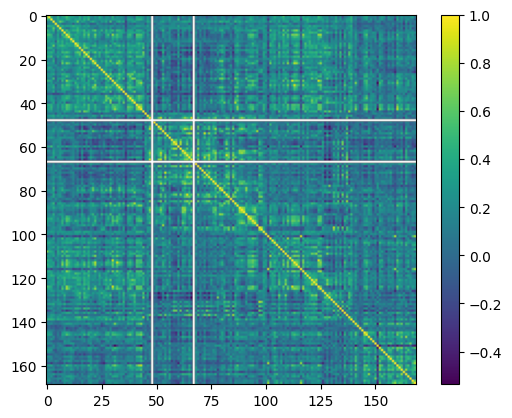

In [6]:
plt.imshow(np.array(corr_list[399]))
plt.colorbar()

Subj 399 contains nans, strategies used are 2 (see figure above):


1.   removing the subject
2.   removing the rows and columns, corresponding to those that in subj n.399 contain nan values, in all subjects



In [7]:
corr_list_array = np.array(corr_list)
corr_mat1 = np.delete(np.delete(corr_list_array, [48, 67], axis=1), [48, 67], axis=2)
corr_mat1.shape

(535, 167, 167)

At this moment corr_mat contains all the matrixes except from that one containing nan values (i.e., n.399), while corr_mat1 contains all matrixes without rows and columns corresponding to those that in the subj. 399 contain nan values

In [8]:
corr_mat = corr_mat1

In [9]:
corr_mat.shape

(535, 167, 167)

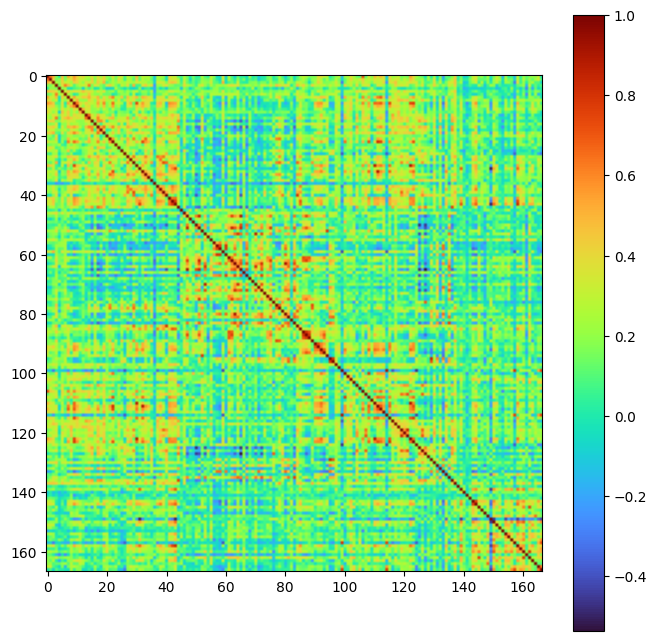

In [10]:
fig = plt.figure(figsize=(8, 8))
chosen_mat = corr_mat[399]
plt.imshow(np.array(chosen_mat), cmap='turbo', vmin=np.min(chosen_mat), vmax=np.max(chosen_mat))
plt.colorbar()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

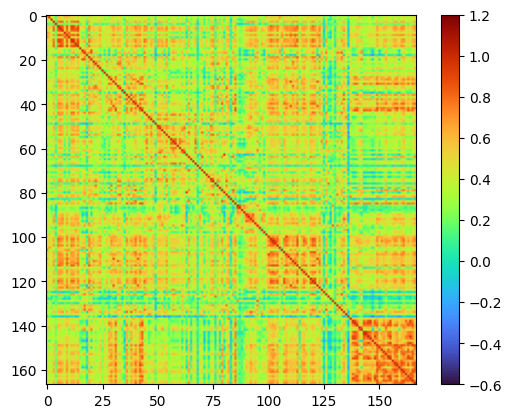

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

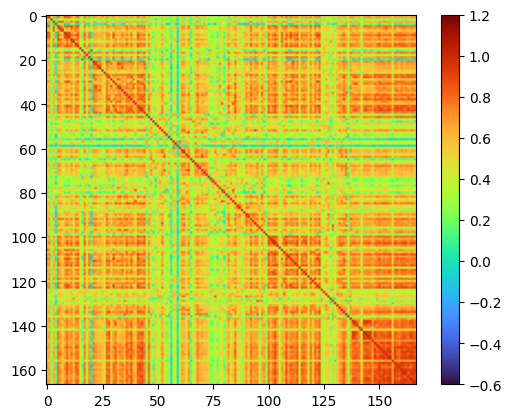

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

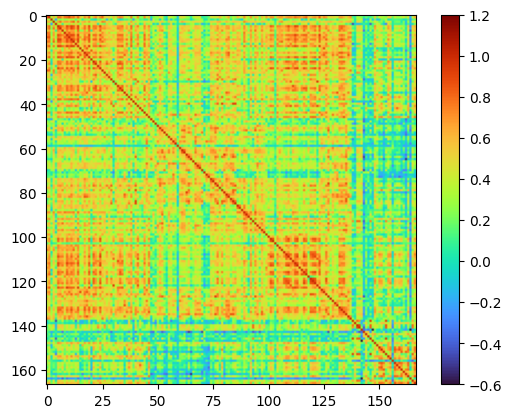

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

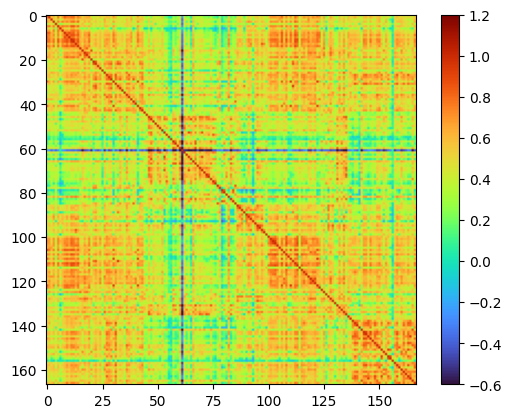

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

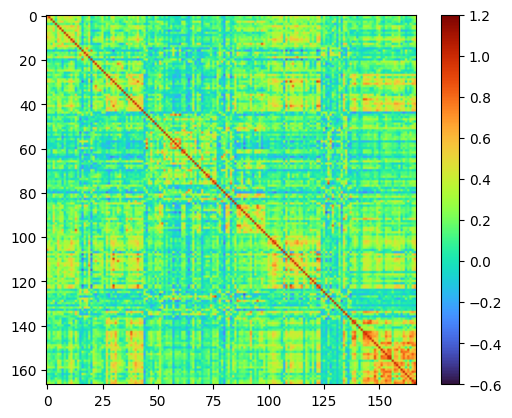

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

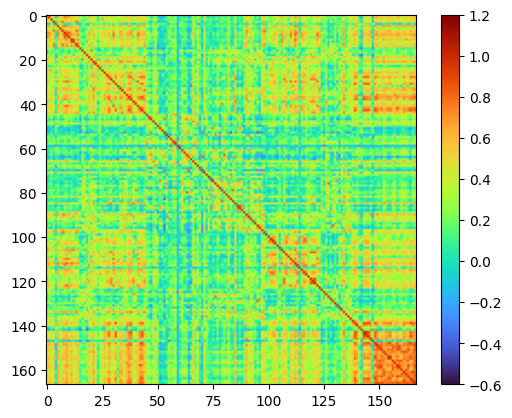

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

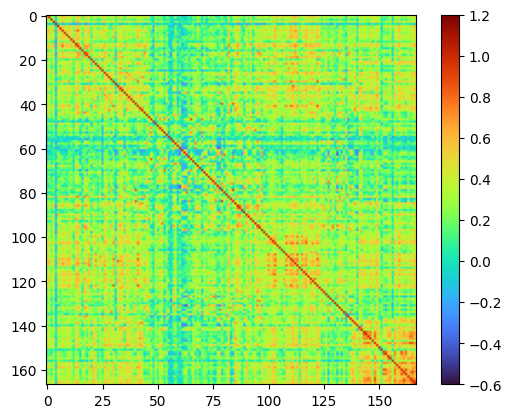

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

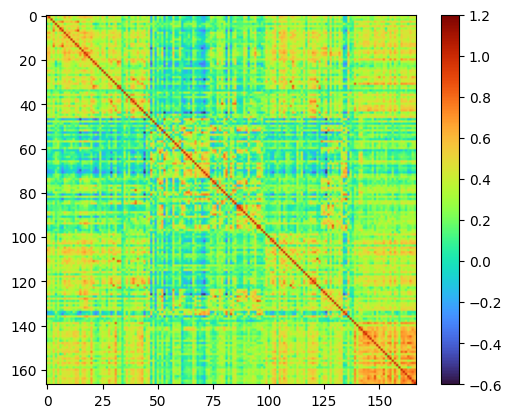

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

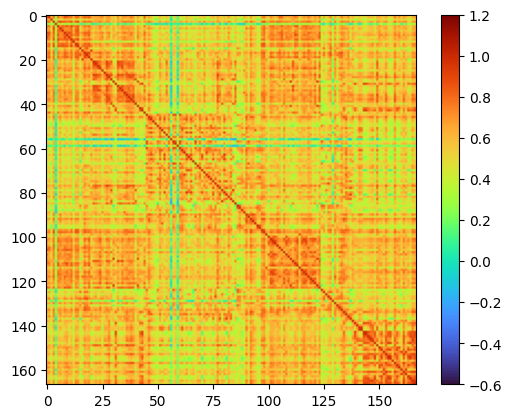

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

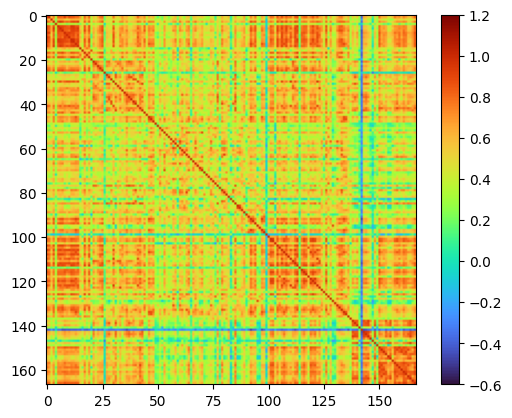

<IPython.core.display.Javascript object>

In [11]:
from matplotlib import pyplot as plt
from google.colab import widgets

tb = widgets.TabBar([str(i + 1) for i in range(10)])
for i in range(10):
    # Only select the first 3 tabs, and render others in the background.
    with tb.output_to(i, select=(i < 3)):
        chosen_mat = corr_mat[i]
        plt.imshow(np.array(chosen_mat), cmap='turbo', vmin=-0.6, vmax=1.2)
        plt.colorbar()
        plt.show()


In [12]:
mean_corr_mat = np.mean(corr_mat[:], 0)
mean_corr_mat

array([[1.        , 0.66234382, 0.43234401, ..., 0.35021772, 0.38201253,
        0.41532322],
       [0.66234382, 1.        , 0.36479527, ..., 0.32800149, 0.37147178,
        0.39409778],
       [0.43234401, 0.36479527, 1.        , ..., 0.22162099, 0.27104682,
        0.26111668],
       ...,
       [0.35021772, 0.32800149, 0.22162099, ..., 1.        , 0.67679433,
        0.62622498],
       [0.38201253, 0.37147178, 0.27104682, ..., 0.67679433, 1.        ,
        0.70438194],
       [0.41532322, 0.39409778, 0.26111668, ..., 0.62622498, 0.70438194,
        1.        ]])

In [13]:
areas = [14, 20, 44, 73, 85, 98, 123, 137, 149]

In [14]:
chosen_mat.shape

(167, 167)

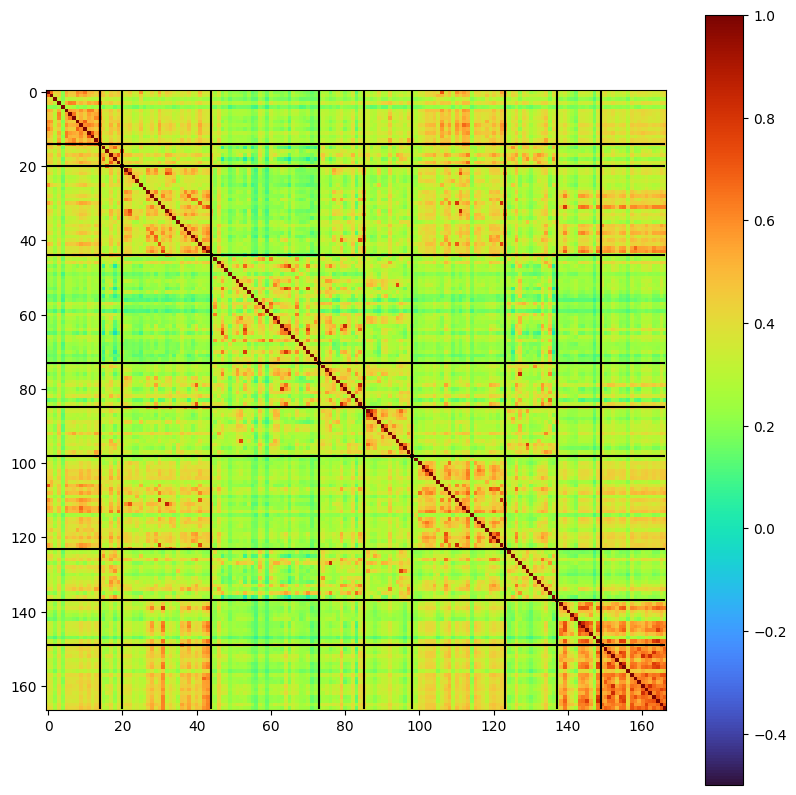

In [15]:
fig = plt.figure(figsize=(10, 10))
chosen_mat = mean_corr_mat
plt.imshow(np.array(chosen_mat), cmap='turbo', vmin=-0.5, vmax=1)
for area in areas:
    plt.plot([0, np.shape(chosen_mat)[1] - 1], [area, area], 'k')
    plt.plot([area, area], [0, np.shape(chosen_mat)[1] - 1], 'k')
plt.colorbar()


In [16]:
def left_symmat(symmetrical_matrix):
    x_matrix, y_matrix = symmetrical_matrix.shape
    if x_matrix != y_matrix:
        raise TypeError('ERROR: the input is not a square matrix!')
    else:
        true_matrix = np.full(symmetrical_matrix.shape, True)
        for i in range(x_matrix):
            for j in range(x_matrix):
                if j >= i:
                    true_matrix[i, j] = False
        return true_matrix

In [17]:
def split_symmat(symmetrical_matrix):
    splitted_array = symmetrical_matrix[left_symmat(symmetrical_matrix)]
    return splitted_array

Here an example:

In [18]:
example_split_symmat = split_symmat(corr_mat[0])
print('the 1st fc matrix is:', example_split_symmat)
print('and its shape is:', example_split_symmat.shape)

the 1st fc matrix is: [0.61416019 0.37671819 0.42510659 ... 0.64273401 0.52654879 0.73635521]
and its shape is: (13861,)


In [19]:
subj_arrays = []
for sub in corr_mat:
    subj_arrays.append(split_symmat(sub))
subj_arrays = np.array(subj_arrays)
subj_arrays.shape

(535, 13861)

Let's check if there are NaN elements in the matrices.

In [20]:
for i in range(len(subj_arrays)):
    for j in range(len(subj_arrays[i])):
        if np.isnan(subj_arrays[i][j]):
            print('There is a NaN in the matrix:', i)
            break

In [21]:
for i in range(len(subj_arrays)):
    for j in range(len(subj_arrays[i])):
        if np.isnan(subj_arrays[i][j]):
            subj_arrays[i][j] = 0

In [22]:
cent_subjs = subj_arrays - np.mean(subj_arrays)
print(subj_arrays.mean())
print(cent_subjs.mean())

0.32291020466941295
5.690370681852711e-17


## Interconnection and Intraconnection values

### Interconnection

In [23]:
reg_coord = [0, 15, 21, 45, 74, 86, 99, 124, 138, 150]

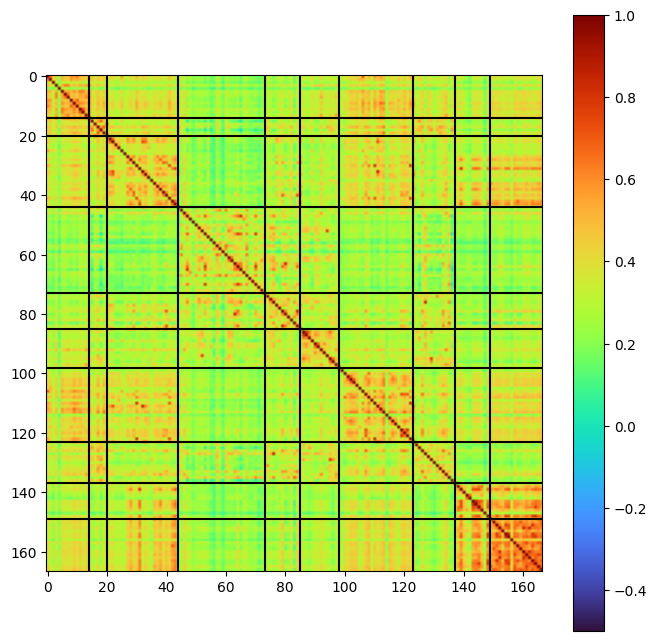

In [24]:
fig = plt.figure(figsize=(8, 8))
chosen_mat = mean_corr_mat
plt.imshow(np.array(chosen_mat), cmap='turbo', vmin=-0.5, vmax=1)
for n_area in range(len(areas)):
    plt.plot([0, 166], [areas[n_area], areas[n_area]], 'k')
    plt.plot([areas[n_area], areas[n_area]], [0, 166], 'k')
plt.colorbar()


The following functions extract inter- and intra-connectivity arrays from the full symmetrical connectivity matrix.

In [25]:
def intercon_mat(symmetrical_matrix, areas_coordinates):
    x_matrix, y_matrix = symmetrical_matrix.shape
    if x_matrix != y_matrix:
        raise TypeError('ERROR: the input is not a square matrix!')
    else:
        true_matrix = np.full(symmetrical_matrix.shape, False)
    for i in range(1, len(areas_coordinates)):
        true_matrix[areas_coordinates[i]:, areas_coordinates[i - 1]:areas_coordinates[i]] = True
    return true_matrix

In [26]:
corr_mat[0][intercon_mat(corr_mat[0], reg_coord)].shape

(12322,)

In [27]:
def intracon_mat(symmetrical_matrix, areas_coordinates):
    x_matrix, y_matrix = symmetrical_matrix.shape
    if x_matrix != y_matrix:
        raise TypeError('ERROR: the input is not a square matrix!')
    else:
        true_matrix = np.full(symmetrical_matrix.shape, False)
    return (left_symmat(symmetrical_matrix) & ~intercon_mat(symmetrical_matrix, areas_coordinates))

In [28]:
intercon_values = [corr_mat[i][intercon_mat(corr_mat[i], reg_coord)] for i in range(corr_mat.shape[0])]
intercon_values = np.array(intercon_values)
intracon_values = [corr_mat[i][intracon_mat(corr_mat[i], reg_coord)] for i in range(corr_mat.shape[0])]
intracon_values = np.array(intracon_values)

In [29]:
print(intercon_values.shape)
print(intracon_values.shape)

(535, 12322)
(535, 1539)


# Data organization

Other variables are stored in the next dataframe:

In [30]:
data = pd.read_excel('drive/MyDrive/SC/CCO/For_Marco.xlsx')
data

ID    Age  Handedness  Education  Sex  BP_Systolic  BP_Diastolic  \
0    CC110045  24.50         100          4    1         90.5          63.5   
1    CC110069  28.67         -58          4    1         94.5          61.5   
2    CC110101  23.33          63          4    0        108.5          63.0   
3    CC110187  25.25        -100          4    1        116.0          71.5   
4    CC110319  28.42         100          4    1        104.0          50.5   
..        ...    ...         ...        ...  ...          ...           ...   
530  CC722542  79.33         100          4    0        149.5          72.0   
531  CC722651  79.83         100          1    1        122.5          63.5   
532  CC722891  84.42          89          0    1        136.5          73.0   
533  CC723197  80.08         100          4    1        186.0          94.0   
534  CC723395  86.08          90          3    1        102.0          50.5   

     Heart_Rate    BMI  MMSE  Group  Unnamed: 11 Unnamed: 12  \
0          61.5  21.66    30      1          NaN         Sex   
1          62.0  22.09    28      1          NaN       Group   
2          78.5  20.39    30      1          NaN         NaN   
3          79.0  21.52    30      1          NaN         NaN   
4          48.5  24.23    30      1          NaN         NaN   
..          ...    ...   ...    ...          ...         ...   
530        51.0  30.96    30      3          NaN         NaN   
531        60.5  22.46    28      1          NaN         NaN   
532        76.0  26.11    26      2          NaN         NaN   
533        64.0  22.72    29      1          NaN         NaN   
534        68.0  30.85    28      3          NaN         NaN   

          Unnamed: 13 Unnamed: 14            Unnamed: 15  Unnamed: 16  \
0              0=Male    1=Female                    NaN          NaN   
1    1= Normal weight         NaN  2=Slightly overweight          NaN   
2                 NaN         NaN                    NaN          NaN   
3                 NaN         NaN                    NaN          NaN   
4                 NaN         NaN                    NaN          NaN   
..                ...         ...                    ...          ...   
530               NaN         NaN                    NaN          NaN   
531               NaN         NaN                    NaN          NaN   
532               NaN         NaN                    NaN          NaN   
533               NaN         NaN                    NaN          NaN   
534               NaN         NaN                    NaN          NaN   

    Unnamed: 17  
0           NaN  
1       3=Obese  
2           NaN  
3           NaN  
4           NaN  
..          ...  
530         NaN  
531         NaN  
532         NaN  
533         NaN  
534         NaN  

[535 rows x 18 columns]

The sample will be split in 3 groups:


1.   Normal weight
2.   Sligtly overweight
3.   Obese

Only the first and the last ones will be taken into account within this study.



In [36]:
norm_weight_ss = data[data['Group'] == 1]
slight_overweight_ss = data[data['Group'] == 2]
obese_ss = data[data['Group'] == 3]

print('there are', len(norm_weight_ss), 'normal weight subjects ')
print('there are', len(slight_overweight_ss), 'slight overweight subjects ')
print('there are', len(obese_ss), 'obese subjects ')

there are 261 normal weight subjects 
there are 183 slight overweight subjects 
there are 91 obese subjects 


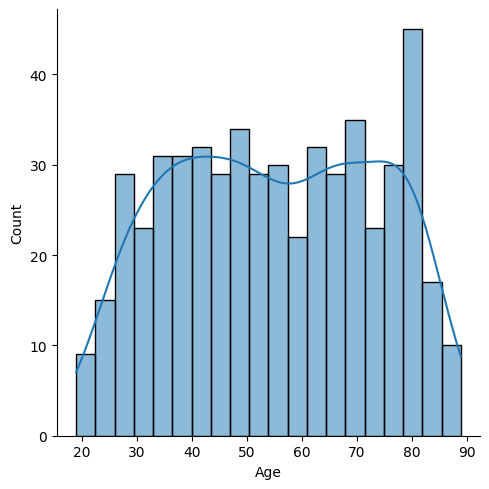

In [37]:
sns.displot(data=data, x='Age', bins=20, kde=True)

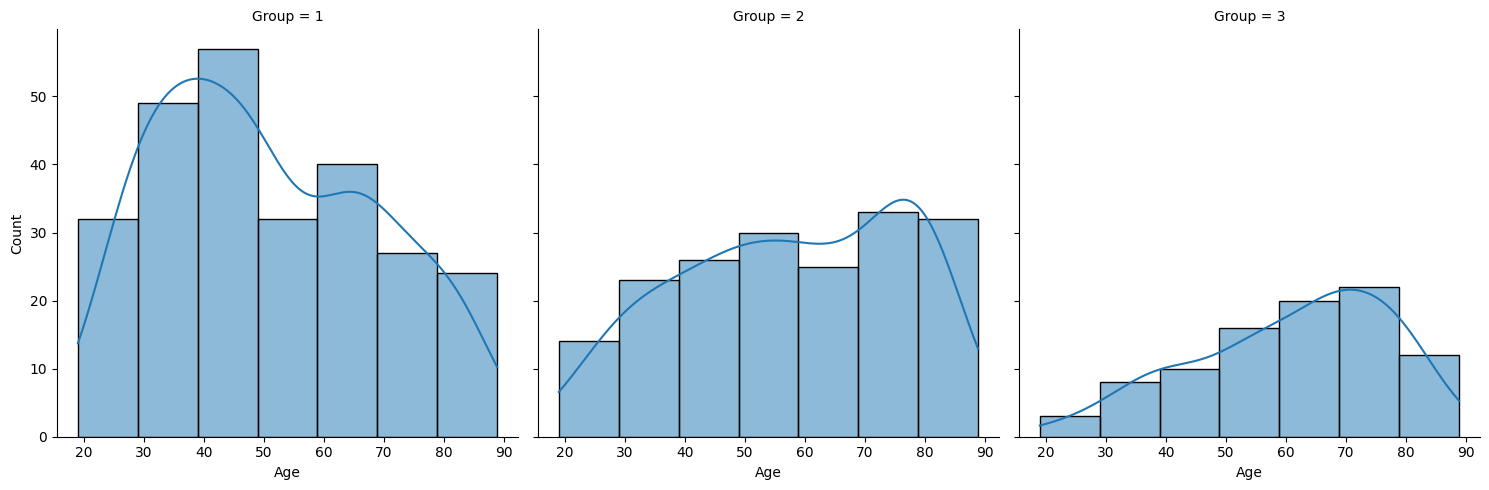

In [38]:
sns.displot(data=data, x='Age', col='Group', bins=7, kde=True)

#OBESE-MATCHED SPLIT

In this section the obese group (O) and a control sample of norm-weight (NWc) subjects matched by age, gender and education with O will be used as test groups. The remaining norm-weighted subjects and the entire set of slight overweigt individuals (SOW) will be used for training the model. Therefore, in this section an out-of-sample prediction is conducted.

In [39]:
#MATCH AGE GENDER & EDUCATION
obese_ss = data[data.Group == 3]
ob_indexes = []
match_indexes = []
norm_sample = norm_weight_ss
ob_excluded = []
for i in range(obese_ss.shape[0]):
    norm_match = np.abs(norm_sample[(norm_sample.Sex == obese_ss.iloc[i]['Sex']) &
                                    (np.abs(norm_sample.Education - obese_ss.iloc[i]['Education']) <= 1)].Age -
                        obese_ss.iloc[i]['Age']).sort_values()
    if np.abs(norm_match.iloc[0]) <= 5:
        match_ind = norm_match.index[0]
        ob_indexes.append(i)
        match_indexes.append(match_ind)
        norm_sample = norm_sample.drop(match_ind)
    else:
        ob_excluded.append(i)
norm_test = norm_weight_ss.loc[match_indexes]
obese_ss_df = obese_ss
excluded_obese = obese_ss.iloc[ob_excluded]
print(obese_ss_df.shape)
obese_ss = obese_ss.iloc[ob_indexes]

(91, 18)


In [40]:
data[data.Group == 2].index

Index([  6,   9,  17,  19,  20,  22,  26,  29,  30,  32,
       ...
       511, 512, 513, 514, 517, 518, 519, 520, 528, 532],
      dtype='int64', length=183)

In [41]:
norm_train = norm_weight_ss.drop(index=norm_test.index)
norm_train

ID    Age  Handedness  Education  Sex  BP_Systolic  BP_Diastolic  \
0    CC110045  24.50         100          4    1         90.5          63.5   
1    CC110069  28.67         -58          4    1         94.5          61.5   
2    CC110101  23.33          63          4    0        108.5          63.0   
4    CC110319  28.42         100          4    1        104.0          50.5   
5    CC110411  25.25         100          4    0         92.5          54.0   
..        ...    ...         ...        ...  ...          ...           ...   
507  CC721107  79.33         100          4    1        128.0          67.5   
516  CC721434  84.92         100          0    0        113.5          73.0   
524  CC721888  78.92          62          4    1        134.0          75.0   
529  CC722536  80.00         -56          4    1        134.0          59.0   
533  CC723197  80.08         100          4    1        186.0          94.0   

     Heart_Rate    BMI  MMSE  Group  Unnamed: 11 Unnamed: 12  \
0          61.5  21.66    30      1          NaN         Sex   
1          62.0  22.09    28      1          NaN       Group   
2          78.5  20.39    30      1          NaN         NaN   
4          48.5  24.23    30      1          NaN         NaN   
5          61.5  19.40    30      1          NaN         NaN   
..          ...    ...   ...    ...          ...         ...   
507        56.0  24.36    28      1          NaN         NaN   
516        98.5  21.17    25      1          NaN         NaN   
524        77.5  23.01    27      1          NaN         NaN   
529        68.0  20.48    30      1          NaN         NaN   
533        64.0  22.72    29      1          NaN         NaN   

          Unnamed: 13 Unnamed: 14            Unnamed: 15  Unnamed: 16  \
0              0=Male    1=Female                    NaN          NaN   
1    1= Normal weight         NaN  2=Slightly overweight          NaN   
2                 NaN         NaN                    NaN          NaN   
4                 NaN         NaN                    NaN          NaN   
5                 NaN         NaN                    NaN          NaN   
..                ...         ...                    ...          ...   
507               NaN         NaN                    NaN          NaN   
516               NaN         NaN                    NaN          NaN   
524               NaN         NaN                    NaN          NaN   
529               NaN         NaN                    NaN          NaN   
533               NaN         NaN                    NaN          NaN   

    Unnamed: 17  
0           NaN  
1       3=Obese  
2           NaN  
4           NaN  
5           NaN  
..          ...  
507         NaN  
516         NaN  
524         NaN  
529         NaN  
533         NaN  

[178 rows x 18 columns]

In [42]:
n_bins = 10
bins_sample = pd.cut(data.Age, bins=n_bins, retbins=True)[1]
bins_sample

array([18.93008, 25.992  , 32.984  , 39.976  , 46.968  , 53.96   ,
       60.952  , 67.944  , 74.936  , 81.928  , 88.92   ])

(0.0, 20.0)

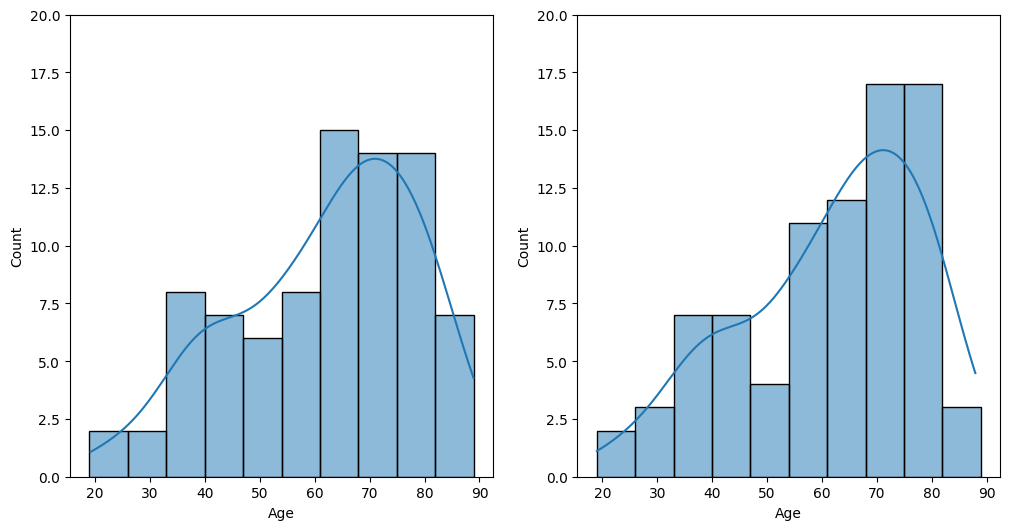

In [43]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
sns.histplot(data=norm_test, x='Age', bins=bins_sample, kde=True, ax=axes[0])
sns.histplot(data=obese_ss, x='Age', bins=bins_sample, kde=True, ax=axes[1])
axes[0].set_ylim([0, 20])
axes[1].set_ylim([0, 20])

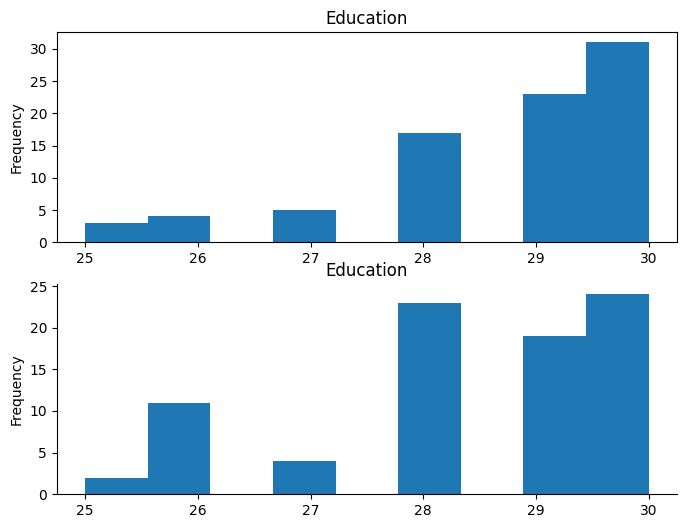

In [44]:
fig, axes = plt.subplots(2, figsize=(8, 6))
norm_test['MMSE'].plot(kind='hist', bins=9, title='Education', ax=axes[0])
obese_ss['MMSE'].plot(kind='hist', bins=9, title='Education', ax=axes[1])
plt.gca().spines[['top', 'right', ]].set_visible(False)

In [45]:
stats.ttest_ind(norm_test.MMSE, obese_ss.MMSE)

TtestResult(statistic=np.float64(1.5720320266641203), pvalue=np.float64(0.11787039486642165), df=np.float64(164.0))

In [46]:
#fig, axes = plt.subplots(ncols=2, figsize=(12,7))
#norm_test.plot(kind='scatter', x='index', y='Age', s=32, alpha=.8, ax= axes[0])
#obese_ss.plot(kind='scatter', x='index', y='Age', s=32, alpha=.8, ax = axes[1])
#plt.gca().spines[['top', 'right',]].set_visible(False)

In [47]:
tt_age = stats.ttest_ind(norm_test.Age, obese_ss.Age)
print(tt_age.pvalue)

0.9169471865162


## Data Used

In the next lines of code it is possible to select the type of data (full connectivity matrix, inter- or intra-connectivity measures)

In [48]:
type_data = [subj_arrays, intercon_values, intracon_values]

In [49]:
type_data[0].shape

(535, 13861)

In [50]:
data_used = type_data[2]  #0=tot; 1=inter; 2=intra
data_used.shape

(535, 12322)

## Model selection


In the following section, we will tune an Elastic Net model using a grid search. The tuning is done on the following hyperparameters:


*   Number of Principal Components
*   Alpha
*   L1 ratio



In [51]:
nw_sow_train_index = np.concatenate((norm_train.index, slight_overweight_ss.index))
#nw_sow_train_index = np.concatenate((norm_train.index, slight_overweight_ss.index, excluded_obese.index))
#nw_sow_train_index = norm_train.index
train_sample = data_used[nw_sow_train_index]
pca = PCA(n_components=.95, svd_solver='auto')
encoded_samples_reduced_PCA_0 = pca.fit_transform(train_sample)
train_age = data.Age[nw_sow_train_index]
y_train_0 = (train_age - np.mean(train_age)) / np.std(train_age)
max_n_comp = encoded_samples_reduced_PCA_0.shape[1]

In [52]:
nw_sow_train_index.shape

(361,)

In [53]:
max_n_comp

247

In [54]:
elastic_net = ElasticNet()
n_components = np.arange(60, max_n_comp + 4, 5)
n_components = [185] #185 intra; 205 inter
l1_ratio = [0.001, 0.25, 0.5, 0.75, 0.99]
alpha = np.logspace(-5, 5, 100)
param_grid = {  # adjust based on the number of features
    'alpha': alpha,
    'l1_ratio': l1_ratio
}
best_score = -100
scores = []
for comp in n_components:
    x_train_0 = (encoded_samples_reduced_PCA_0[:, 0:comp] - np.mean(encoded_samples_reduced_PCA_0[:, 0:comp])) / np.std(
        encoded_samples_reduced_PCA_0[:, 0:comp])
    # Set up GridSearchCV
    train_age_cat = pd.cut(y_train_0, bins=10, labels=range(10))
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=2)
    kf.get_n_splits(x_train_0)
    grid_search = GridSearchCV(elastic_net, param_grid, cv=kf.split(x_train_0, train_age_cat), scoring='r2', n_jobs=-1)
    # Fit the model
    grid_search.fit(x_train_0, y_train_0)
    # Best parameters and model
    if grid_search.best_score_ >= best_score:
        best_score = grid_search.best_score_
        best_n_components = comp
        best_parameters = grid_search.best_params_

print("Best cross-validation score: ", best_score)
print("best number of components: ", best_n_components)
print("best parameters:", best_parameters)

Best cross-validation score:  0.5582524531789836
best number of components:  205
best parameters: {'alpha': np.float64(0.2782559402207126), 'l1_ratio': 0.001}


In [55]:
n_comp = best_n_components

After selecting the hyperparameters, the test datasets were standardized. The Elastic Net model was then trained on the training set using these hyperparameters and subsequently evaluated on the test datasets.

In [56]:
nw_sow_train_index = np.concatenate((norm_train.index, slight_overweight_ss.index))
#nw_sow_train_index = np.concatenate((norm_train.index, slight_overweight_ss.index, excluded_obese.index))
#nw_sow_train_index = norm_train.index
train_sample = data_used[nw_sow_train_index]
pca = PCA(n_components=n_comp, svd_solver='auto')
encoded_samples_reduced_PCA = pca.fit_transform(train_sample)
print('pca components shape:', encoded_samples_reduced_PCA.shape)
x_test = (pca.transform(data_used[norm_test.index]) - np.mean(encoded_samples_reduced_PCA)) / np.std(
    encoded_samples_reduced_PCA)
x_train = (encoded_samples_reduced_PCA - np.mean(encoded_samples_reduced_PCA)) / np.std(encoded_samples_reduced_PCA)
print(x_train.shape)
print(x_test.shape)

train_age = data.Age[nw_sow_train_index]
y_test = (data.Age[norm_test.index] - np.mean(train_age)) / np.std(train_age)
y_train = (train_age - np.mean(train_age)) / np.std(train_age)
print(y_train.shape)
print(y_test.shape)
ob_age = obese_ss.Age
norm_ob_age = (ob_age - np.mean(train_age)) / np.std(train_age)

pca components shape: (361, 205)
(361, 205)
(83, 205)
(361,)
(83,)


In [57]:
norm_test.index

Index([ 10,  40,   3,  96,  71,  93, 100, 103, 126, 107, 149, 212, 195, 204,
       214, 203, 173, 175, 161, 274, 270, 225, 256, 251, 290, 292, 281, 235,
       269, 252, 289, 316, 359, 326, 337, 310, 349, 365, 332, 360, 374, 314,
       354, 357, 329, 347, 370, 308, 328, 436, 420, 386, 398, 391, 430, 425,
       459, 488, 444, 414, 531, 383, 400, 442, 450, 453, 421, 439, 403, 451,
       496, 487, 521, 429, 503, 476, 478, 522, 502, 525, 499, 485, 527],
      dtype='int64')

In [58]:
print(x_train.mean())
print(x_train.std())

2.640352034781806e-18
1.0


In [59]:
el_reg = ElasticNet(alpha=best_parameters['alpha'], l1_ratio=best_parameters['l1_ratio'], random_state=10)
el_reg.fit(x_train, y_train)

ElasticNet(alpha=np.float64(0.2782559402207126), l1_ratio=0.001,
           random_state=10)

In [60]:
split_test = True
normal_setting = True

In [61]:
dataframes = []
comparisons = [[y_train, el_reg.predict(x_train)]]
print('score of the model computed on the train dataset:', el_reg.score(x_train, y_train))
comparisons.append([y_test, el_reg.predict(x_test)])
print('score of the model computed on the test dataset:', el_reg.score(x_test, y_test))
for comp in comparisons:
    comp[0] = comp[0] * np.std(train_age) + np.mean(train_age)
    comp[1] = comp[1] * np.std(train_age) + np.mean(train_age)
print('number of comparisons (true age vs prediction):', len(comparisons))
for comp, sample in zip(comparisons, ['train', 'test']):
    print('mean absolute error (in years) of the model predictions on the', sample, 'dataset',
          np.mean(np.abs(comp[0] - comp[1])))
    df = pd.DataFrame({sample + ' true age': comp[0], 'prediction': comp[1], 'error': np.abs(comp[1] - comp[0])})
    dataframes.append(df)
    print(df)

score of the model computed on the train dataset: 0.8146980650616824
score of the model computed on the test dataset: 0.4473268980570029
number of comparisons (true age vs prediction): 2
mean absolute error (in years) of the model predictions on the train dataset 6.347621738575825
     train true age  prediction      error
0             24.50   29.699077   5.199077
1             28.67   31.971746   3.301746
2             23.33   33.351138  10.021138
4             28.42   35.657991   7.237991
5             25.25   41.456881  16.206881
..              ...         ...        ...
518           79.25   76.125604   3.124396
519           81.83   60.017689  21.812311
520           80.75   74.912715   5.837285
528           79.42   71.124360   8.295640
532           84.42   76.361418   8.058582

[361 rows x 3 columns]
mean absolute error (in years) of the model predictions on the test dataset 9.906327588984954
     test true age  prediction      error
10           19.17   40.578257  21.408257


In [62]:
train_df = dataframes[0]
train_df['error'] = train_df['prediction'] - train_df['train true age']
test_df = dataframes[1]
test_df['error'] = test_df['prediction'] - test_df['test true age']

In [63]:
test_df['error'].mean()

np.float64(-6.617707709203301)

In [64]:
test_df['error'].std()

10.200456420776046

In [131]:
nw_score = el_reg.score(x_test, y_test)
print(nw_score)
nw_mae = np.mean(np.abs(test_df['error']))
print(nw_mae)

0.4473268980570029
9.906327588984954


In [65]:
norm_ob_values = (pca.transform(data_used[obese_ss.index]) - np.mean(encoded_samples_reduced_PCA)) / np.std(
    encoded_samples_reduced_PCA)
norm_ob_values.shape

(83, 205)

In [66]:
ob_predictions = (el_reg.predict(norm_ob_values) * np.std(train_age)) + train_age.mean()

In [67]:
error_ob = ob_predictions - ob_age
error_ob

23     22.804268
37     10.149923
38     25.156459
62      2.499613
66      5.169709
         ...    
515   -25.519255
523     0.500995
526    -3.148429
530   -22.356121
534   -21.938468
Name: Age, Length: 83, dtype: float64

In [68]:
error_ob.mean()

np.float64(-3.541566999634924)

In [69]:
error_ob.std()

11.336011281684929

In [70]:
ob_score = el_reg.score(norm_ob_values, norm_ob_age)
print(ob_score)
abs_err_ob = np.abs(error_ob)
mae_ob = abs_err_ob.mean()
print(mae_ob)

0.4655193120296275
9.287040161900746


### stats

In [71]:
error_ob.mean() - test_df['error'].mean()

np.float64(3.0761407095683766)

In [72]:
err_nw_test = test_df['error']
tt_ob = stats.ttest_ind(error_ob, err_nw_test, equal_var=False)
print('norm test and obese:', tt_ob)

norm test and obese: TtestResult(statistic=np.float64(1.8377350740218303), pvalue=np.float64(0.06793090726194925), df=np.float64(162.2061621578379))


In [73]:
norm_ss_df = dataframes[0].rename(columns={'train true age': "true age", 'error': "absolute error"})
norm_ss_df['error'] = (norm_ss_df['prediction'] - norm_ss_df['true age']).values
norm_ss_df['group'] = np.repeat('TR', len(norm_ss_df))
norm_ss_df

true age  prediction  absolute error      error group
0       24.50   29.699077        5.199077   5.199077    TR
1       28.67   31.971746        3.301746   3.301746    TR
2       23.33   33.351138       10.021138  10.021138    TR
4       28.42   35.657991        7.237991   7.237991    TR
5       25.25   41.456881       16.206881  16.206881    TR
..        ...         ...             ...        ...   ...
518     79.25   76.125604       -3.124396  -3.124396    TR
519     81.83   60.017689      -21.812311 -21.812311    TR
520     80.75   74.912715       -5.837285  -5.837285    TR
528     79.42   71.124360       -8.295640  -8.295640    TR
532     84.42   76.361418       -8.058582  -8.058582    TR

[361 rows x 5 columns]

In [74]:
test_ss_df = test_df.rename(columns={'test true age': "true age"})
test_ss_df['group'] = np.repeat('NWc', len(test_df))
test_ss_df
err_pred_test = test_ss_df['error']
std_test = pd.DataFrame({'true age': test_ss_df['true age'], 'error': test_ss_df['error'],
                         'z_err': (err_pred_test - np.mean(err_pred_test)) / np.std(err_pred_test),
                         'group': np.repeat('NW', len(ob_age))})

In [75]:
ob_df = pd.DataFrame(
    {'true age': ob_age, 'prediction': ob_predictions, 'absolute error': np.abs(error_ob), 'error': error_ob,
     'group': np.repeat('O', len(ob_age))})
tot_ss_df = pd.concat([norm_ss_df, ob_df], ignore_index=True)
std_ob = pd.DataFrame(
    {'true age': ob_age, 'error': error_ob, 'z_err': (ob_df['error'] - np.mean(err_pred_test)) / np.std(err_pred_test),
     'group': np.repeat('O', len(ob_age))})
tot_ss_df = pd.concat([norm_ss_df, ob_df, test_ss_df], ignore_index=True)
tot_std = pd.concat([std_test, std_ob], ignore_index=True)

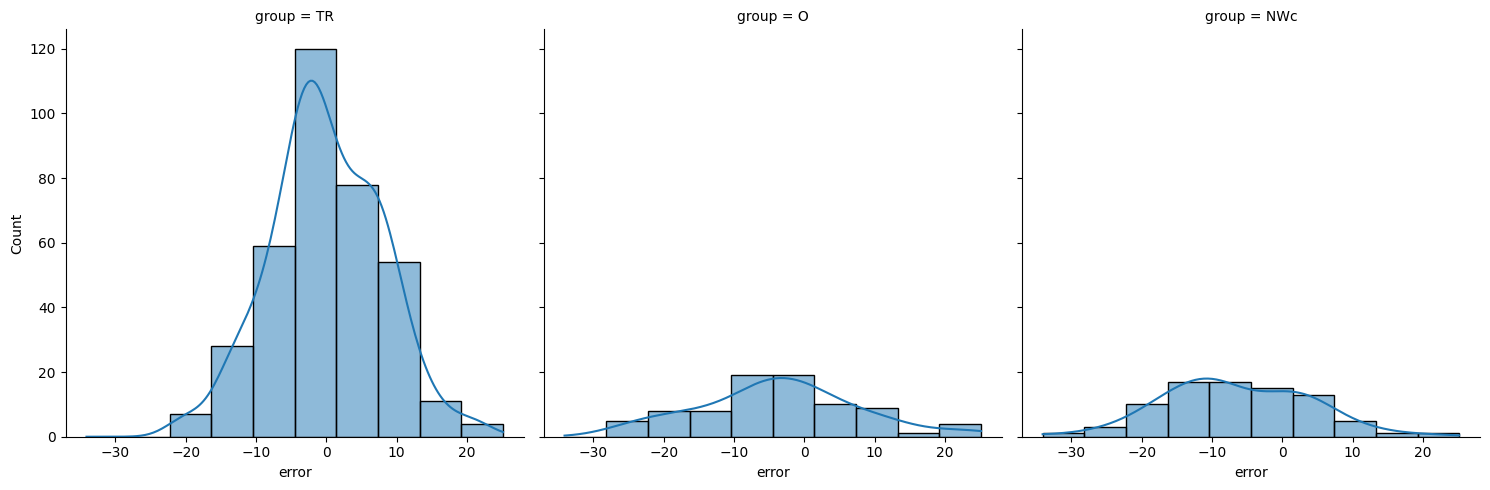

In [76]:
sns.displot(data=tot_ss_df, x='error', col='group', bins=10, kde=True)

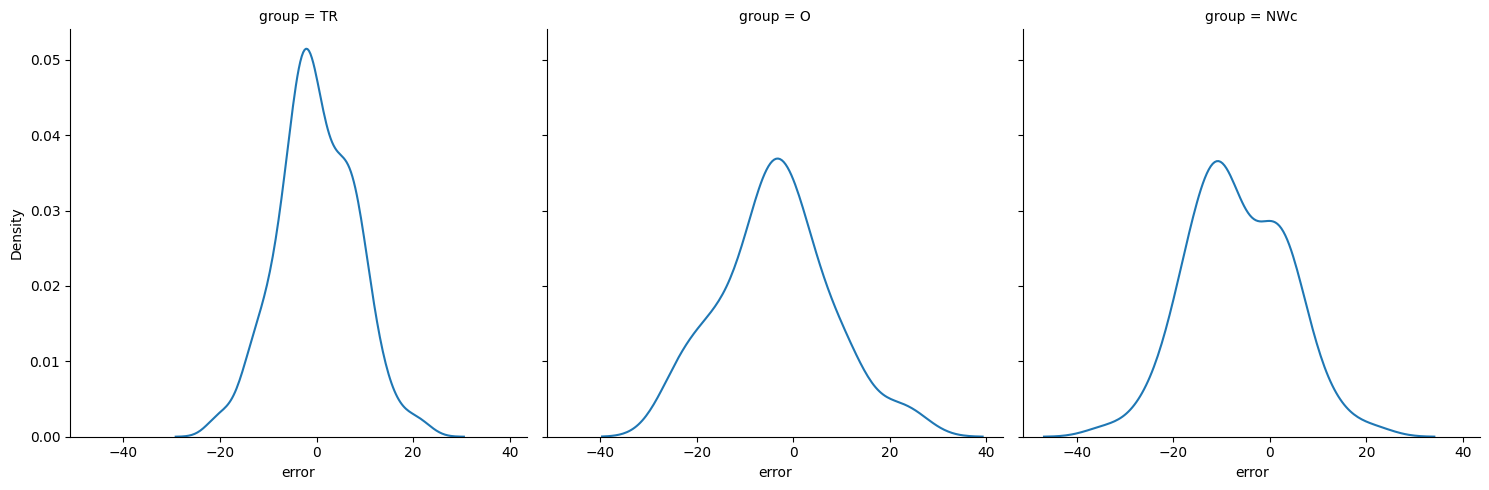

In [77]:
sns.displot(data=tot_ss_df, x='error', col='group', kind='kde', common_norm=False)

In [78]:
fig7 = px.scatter(tot_ss_df, x='true age', y='prediction', labels={'x': 'true age', 'y': 'prediction'}, height=600,
                  facet_col='group')
trace = go.Scatter(x=[18, 90], y=[18, 90], mode='lines', line_color='red', name='optimal prediction')
trace.update(showlegend=False)
fig7.add_trace(trace, row='all', col='all')
fig7.update_traces(selector=-1, showlegend=True)
fig7.update_xaxes(showgrid=False)
fig7.update_yaxes(showline=True, linecolor='black', showgrid=False)
fig7.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
)
fig7.for_each_yaxis(lambda yax: yax.update(showticklabels=True))
fig7.show()

In [79]:
fig6 = px.scatter(tot_ss_df, x='true age', y='error', labels={'x': 'true age', 'y': 'prediction error'},
                  trendline="ols", height=600, facet_col='group')
#trace = go.Scatter(x=[18,100],y=[0,0], mode='lines', line_color='black', name='no prediction error')
#trace.update(showlegend=False)
#fig6.add_trace(trace, row='all', col='all')
#fig6.update_traces(selector=-1, showlegend=True)
fig6.show()

In [80]:
fig6 = px.scatter(tot_std, x='true age', y='z_err', labels={'x': 'true age', 'y': 'z (prediction error)'},
                  trendline="ols", height=600, facet_col='group')
fig6.update_traces(selector=-1, showlegend=True)
fig6.update_xaxes(showgrid=False)
fig6.update_yaxes(showline=True, linecolor='black', showgrid=False)
fig6.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
)
fig6.for_each_yaxis(lambda yax: yax.update(showticklabels=True))
fig6.show()

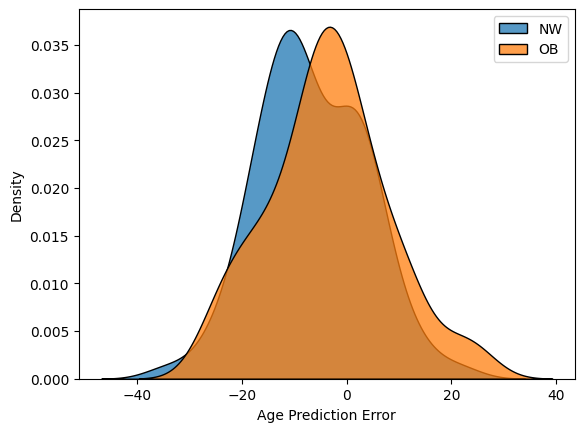

In [81]:
kd1 = sns.kdeplot(test_ss_df, x='error', multiple='stack', label='NW')
kd2 = sns.kdeplot(ob_df, x='error', multiple='stack', label='OB')
plt.xlabel('Age Prediction Error')
plt.legend()

(-40.0, 40.0)

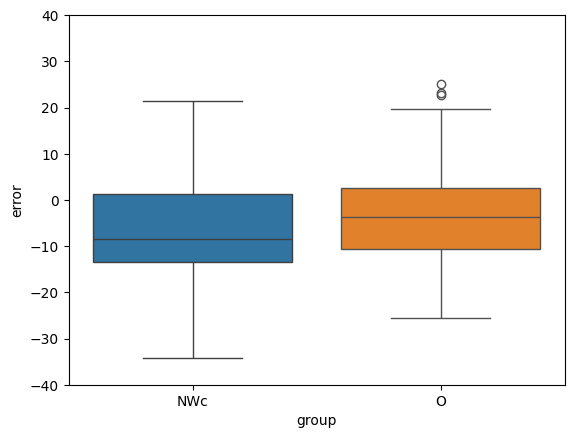

In [82]:
sns.boxplot(data=test_ss_df, x='group', y='error')
sns.boxplot(data=ob_df, x='group', y='error')
plt.ylim(-40, 40)

In [83]:
bins = [18, 40, 60, 90]

<Figure size 1800x500 with 0 Axes>

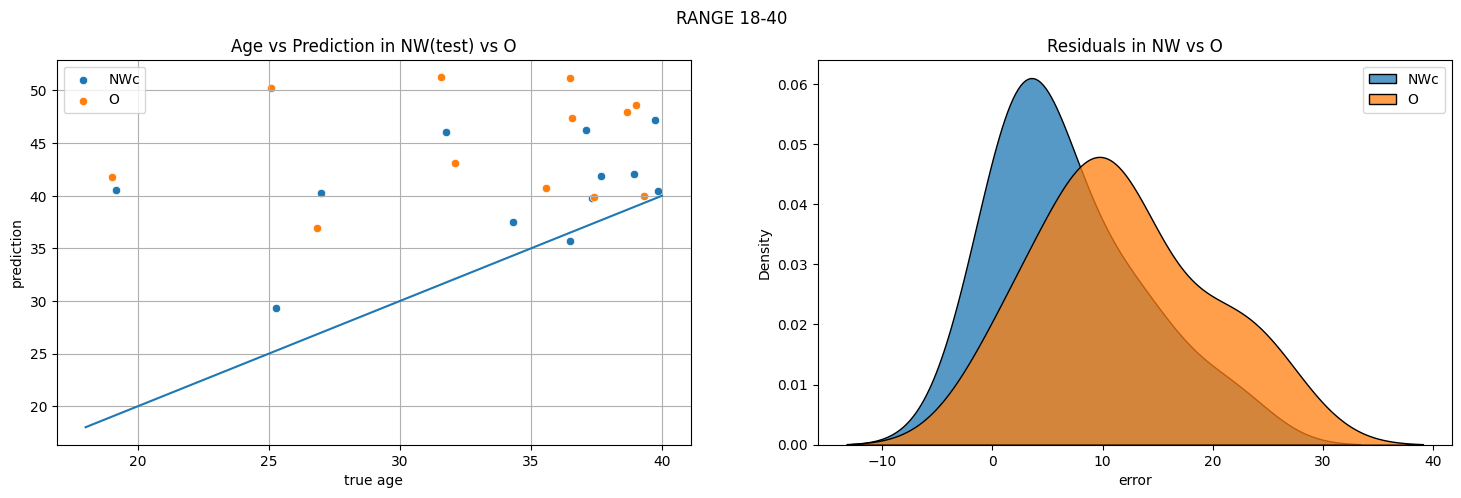

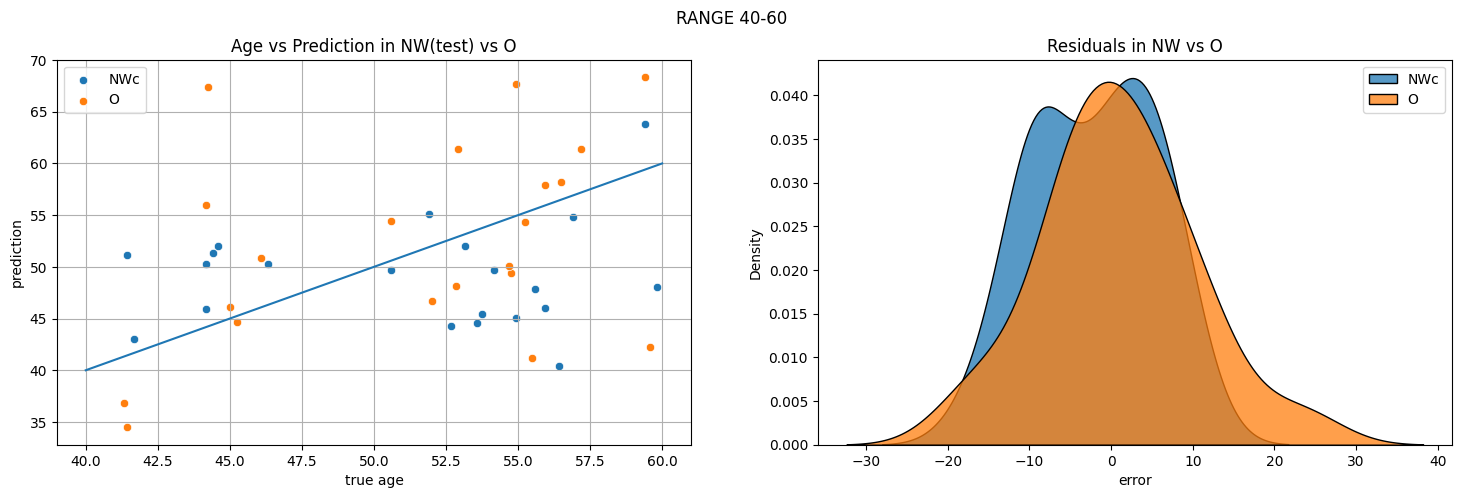

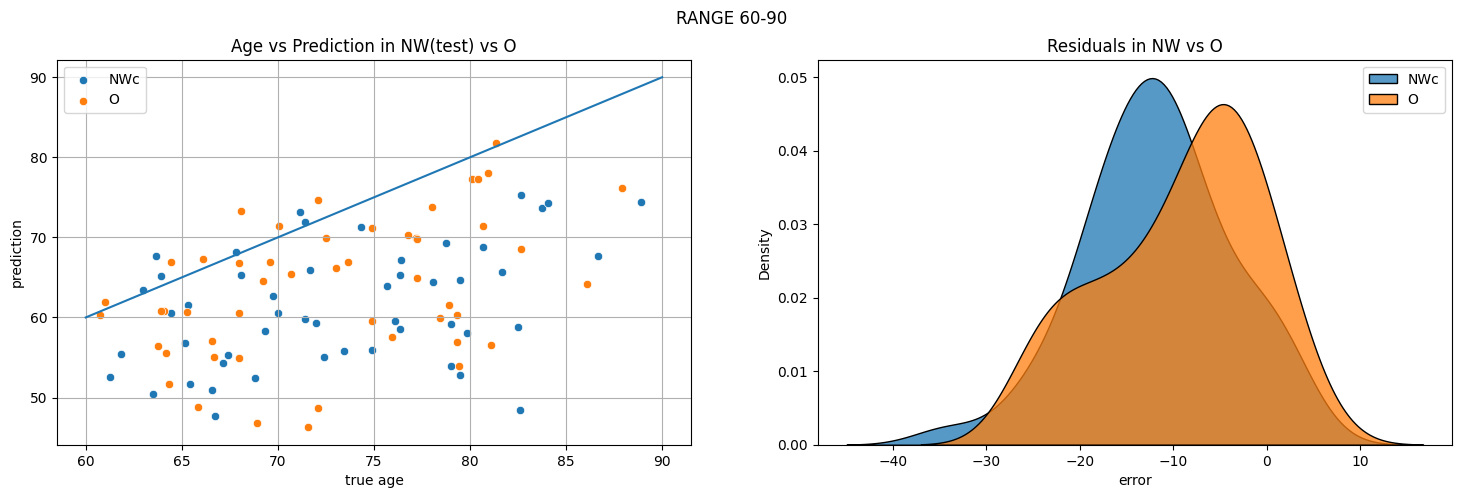

In [84]:
fig11 = plt.figure(layout='constrained', figsize=(18, 5))
subfig = fig11.subfigures(len(bins) - 1, 1)
for bin_id in range(len(bins) - 1):
    subfig[bin_id], axes = plt.subplots(ncols=2, figsize=(18, 5))
    subfig[bin_id].suptitle('RANGE ' + str(bins[bin_id]) + '-' + str(bins[bin_id + 1]))
    test_bin_df = test_ss_df[(bins[bin_id] < test_ss_df['true age']) & (test_ss_df['true age'] < bins[bin_id + 1])]
    ob_bin = ob_df[(bins[bin_id] <= ob_df['true age']) & (ob_df['true age'] < bins[bin_id + 1])]
    sc1 = sns.scatterplot(test_bin_df, x='true age', y='prediction', ax=axes[0], label='NWc')
    sc2 = sns.scatterplot(ob_bin, x='true age', y='prediction', ax=axes[0], label='O')
    sns.lineplot(x=[bins[bin_id], bins[bin_id + 1]], y=[bins[bin_id], bins[bin_id + 1]], ax=axes[0])
    kd1 = sns.kdeplot(test_bin_df, x='error', ax=axes[1], multiple='stack', label='NWc')
    kd2 = sns.kdeplot(ob_bin, x='error', ax=axes[1], multiple='stack', label='O')
    axes[0].title.set_text('Age vs Prediction in NW(test) vs O')
    axes[1].title.set_text('Residuals in NW vs O')
    axes[0].legend()
    axes[1].legend()
    axes[0].grid()

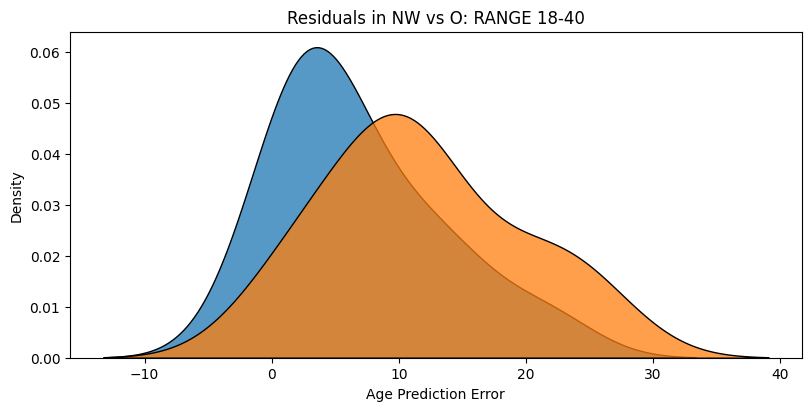

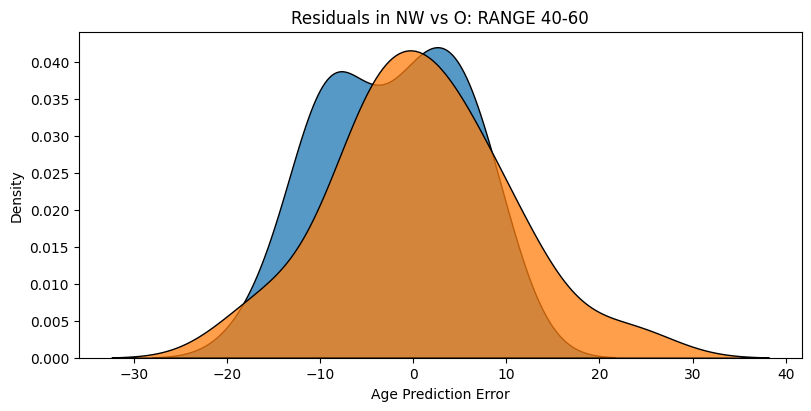

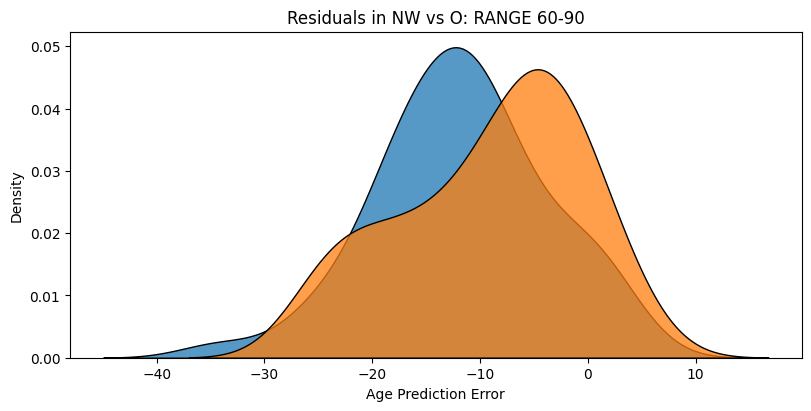

In [85]:

for bin_id in range(len(bins) - 1):
    plt.figure(layout='constrained', figsize=(8, 4))
    plt.title('Residuals in NW vs O: RANGE ' + str(bins[bin_id]) + '-' + str(bins[bin_id + 1]))
    test_bin_df = test_ss_df[(bins[bin_id] < test_ss_df['true age']) & (test_ss_df['true age'] < bins[bin_id + 1])]
    ob_bin = ob_df[(bins[bin_id] <= ob_df['true age']) & (ob_df['true age'] < bins[bin_id + 1])]
    kd1 = sns.kdeplot(test_bin_df, x='error', multiple='stack', label='NWc')
    kd2 = sns.kdeplot(ob_bin, x='error', multiple='stack', label='O')
    plt.xlabel('Age Prediction Error')
    plt.show()

In [86]:
intervals = []
small_df = [test_ss_df, ob_df]
dataf_means = [[], []]
errors_df = [[], []]
std_devs = [[], [], []]
for bin_id in range(len(bins) - 1):
    intervals.append(str(bins[bin_id]) + '-' + str(bins[bin_id + 1]))
    for dfi in range(len(small_df)):
        dataf_bin = small_df[dfi]
        dfi_bin = dataf_bin[(bins[bin_id] <= dataf_bin['true age']) & (dataf_bin['true age'] < bins[bin_id + 1])]
        errors_df[dfi].append(dfi_bin['error'].values)
        dataf_means[dfi].append(dfi_bin['error'].mean())
        std_devs[dfi].append(dfi_bin['error'].std())
print(intervals)
print(dataf_means)
print(std_devs)

['18-40', '40-60', '60-90']
[[np.float64(6.87432713677649), np.float64(-2.1403966908480934), np.float64(-11.736266699947636)], [np.float64(11.792671373080323), np.float64(0.8635805669223644), np.float64(-9.071946187040645)]]
[[6.5587681461132705, 7.362442725376944, 7.901647300435179], [7.625529403663373, 9.238824295651154, 8.369327321303379], []]


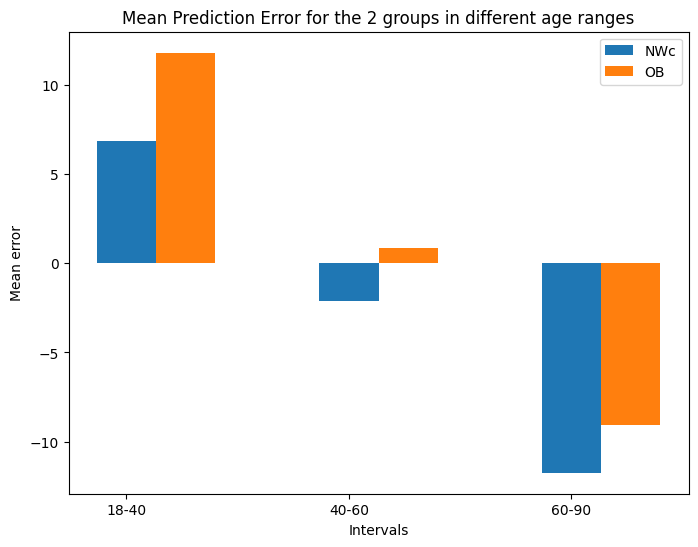

In [87]:
barfig = plt.figure(figsize=(8, 6))
labels_df = ['NWc', 'OB']
inter = np.arange(len(intervals)) * 3
for lab in range(len(labels_df)):
    plt.bar(inter + lab * 0.8, dataf_means[lab], label=labels_df[lab])
plt.xticks(inter, intervals)
plt.xlabel("Intervals")
plt.ylabel("Mean error")
plt.title("Mean Prediction Error for the 2 groups in different age ranges")
plt.legend()
plt.show()

In [88]:
for bin_i in range(len(errors_df[0])):
    print('#### BIN [', bins[bin_i], '-', bins[bin_i + 1], '] ####')
    print('####### t-test #######')
    ob_nw_tt = stats.ttest_ind(errors_df[1][bin_i], errors_df[0][bin_i], equal_var=False)
    print('norm test and obese:', ob_nw_tt)


#### BIN [ 18 - 40 ] ####
####### t-test #######
norm test and obese: TtestResult(statistic=np.float64(1.6939163451371106), pvalue=np.float64(0.10470815284140042), df=np.float64(21.51861331667541))
#### BIN [ 40 - 60 ] ####
####### t-test #######
norm test and obese: TtestResult(statistic=np.float64(1.165261965386983), pvalue=np.float64(0.25115640031428155), df=np.float64(38.1018106386639))
#### BIN [ 60 - 90 ] ####
####### t-test #######
norm test and obese: TtestResult(statistic=np.float64(1.6367923020830468), pvalue=np.float64(0.10489192592118539), df=np.float64(97.67773823758944))


<Figure size 800x600 with 0 Axes>

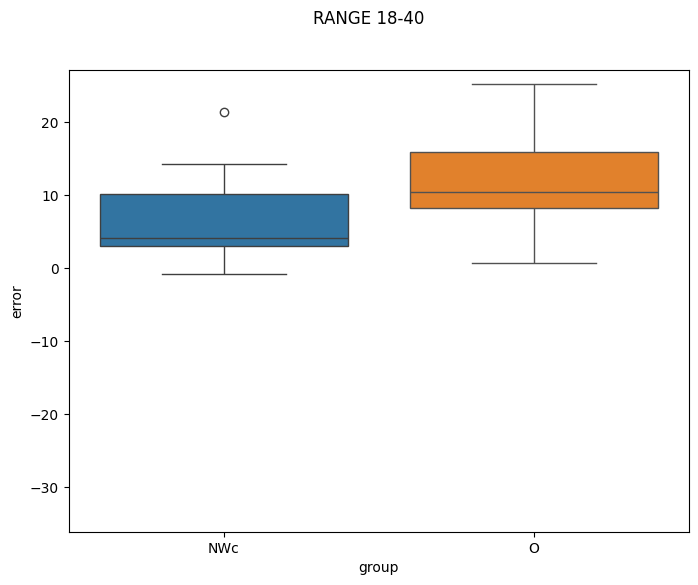

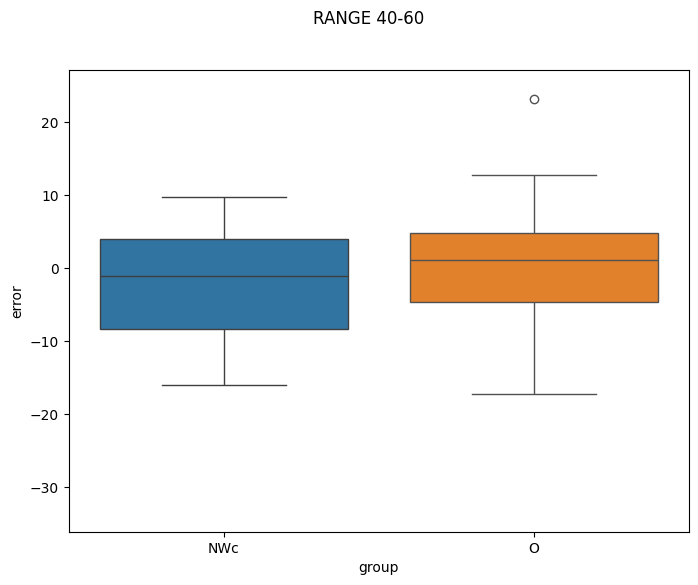

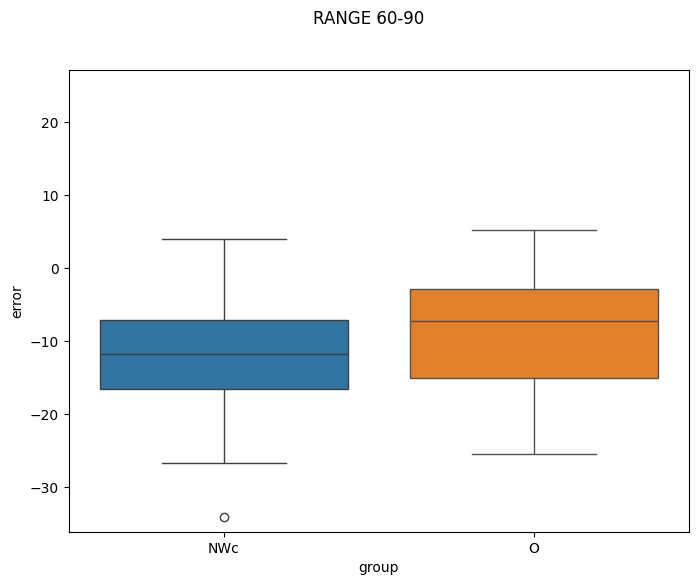

In [89]:
fig11 = plt.figure(layout='constrained', figsize=(8, 6))
subfig = fig11.subfigures(len(bins) - 1, 1)
for bin_id in range(len(bins) - 1):
    subfig[bin_id] = plt.figure(figsize=(8, 6))
    subfig[bin_id].suptitle('RANGE ' + str(bins[bin_id]) + '-' + str(bins[bin_id + 1]))
    test_bin_df = test_ss_df[(bins[bin_id] < test_ss_df['true age']) & (test_ss_df['true age'] < bins[bin_id + 1])]
    ob_bin = ob_df[(bins[bin_id] <= ob_df['true age']) & (ob_df['true age'] < bins[bin_id + 1])]
    sc1 = sns.boxplot(test_bin_df, x='group', y='error')
    sc2 = sns.boxplot(ob_bin, x='group', y='error')
    plt.ylim([np.min(np.concatenate((ob_df['error'], test_ss_df['error']))) - 2,
              np.max(np.concatenate((ob_df['error'], test_ss_df['error']))) + 2])

<Figure size 800x600 with 0 Axes>

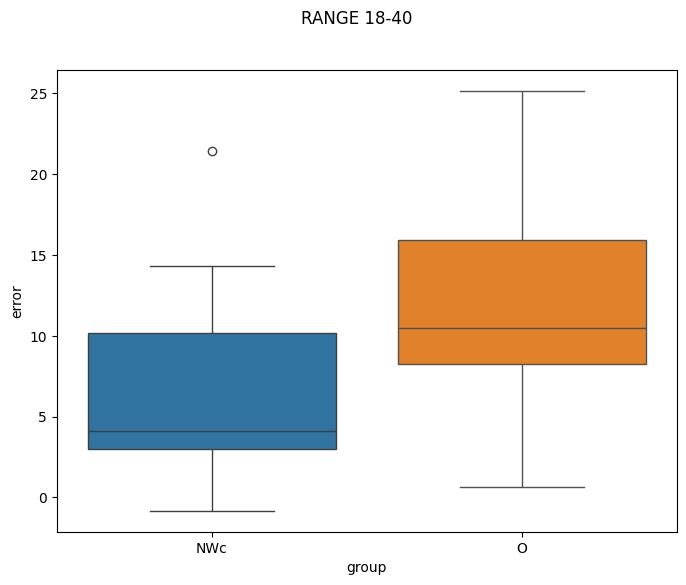

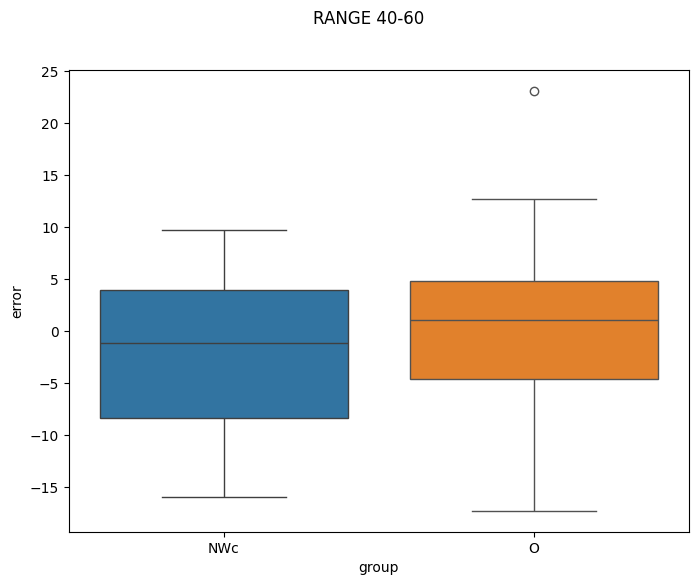

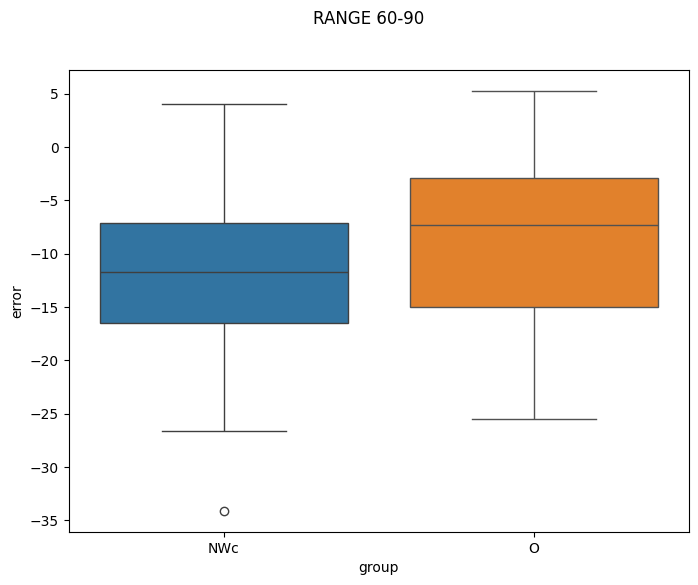

In [90]:
fig11 = plt.figure(layout='constrained', figsize=(8, 6))
subfig = fig11.subfigures(len(bins) - 1, 1)
for bin_id in range(len(bins) - 1):
    subfig[bin_id] = plt.figure(figsize=(8, 6))
    subfig[bin_id].suptitle('RANGE ' + str(bins[bin_id]) + '-' + str(bins[bin_id + 1]))
    test_bin_df = test_ss_df[(bins[bin_id] < test_ss_df['true age']) & (test_ss_df['true age'] < bins[bin_id + 1])]
    ob_bin = ob_df[(bins[bin_id] <= ob_df['true age']) & (ob_df['true age'] < bins[bin_id + 1])]
    sc1 = sns.boxplot(test_bin_df, x='group', y='error')
    sc2 = sns.boxplot(ob_bin, x='group', y='error')
    #plt.ylim([np.min(np.concatenate((ob_df['error'], test_ss_df['error'])))-2, np.max(np.concatenate((ob_df['error'], test_ss_df['error'])))+2])

##CORRECTIONS (on residuals)


Predicted brain age (as well as brain age delta) typically shows overestimation in younger individuals and underestimation in older individuals. For this reason, it is important to Remove this age-bias to ensure that any further analyses are not influenced by the age-dependence of the predictions.

This correction is typically done by fitting a regression model on predicted age as a function of chronological age. The slope and intercept of the regression model are then used to compute the corrected predicted age, that is used to derive corrected delta values (i.e., corrected brain age delta = corrected predicted age – chronological age)

In [91]:
figu2 = px.scatter(norm_ss_df, x='true age', y='error', labels={'x': 'true age', 'y': 'prediction error'},
                   trendline="ols", height=600, width=800)
figu2.show()

In [92]:
b0, b1 = px.get_trendline_results(figu2).px_fit_results.iloc[0].params
print('intercept:', b0)
print('slope:', b1)

intercept: 15.31444907803367
slope: -0.29594912576129156


In [93]:
test_df

test true age  prediction      error
10           19.17   40.578257  21.408257
40           27.00   40.279786  13.279786
3            25.25   29.338712   4.088712
96           37.67   41.837357   4.167357
71           37.33   39.760566   2.430566
..             ...         ...        ...
502          79.50   52.854986 -26.645014
525          83.75   73.653349 -10.096651
499          84.08   74.306538  -9.773462
485          82.58   48.471829 -34.108171
527          86.67   67.637628 -19.032372

[83 rows x 3 columns]

In [94]:
test_ss_df.index

Index([ 10,  40,   3,  96,  71,  93, 100, 103, 126, 107, 149, 212, 195, 204,
       214, 203, 173, 175, 161, 274, 270, 225, 256, 251, 290, 292, 281, 235,
       269, 252, 289, 316, 359, 326, 337, 310, 349, 365, 332, 360, 374, 314,
       354, 357, 329, 347, 370, 308, 328, 436, 420, 386, 398, 391, 430, 425,
       459, 488, 444, 414, 531, 383, 400, 442, 450, 453, 421, 439, 403, 451,
       496, 487, 521, 429, 503, 476, 478, 522, 502, 525, 499, 485, 527],
      dtype='int64')

In [95]:
corr_tr = norm_ss_df['prediction'] - (b1 * norm_ss_df['true age'] + b0)
corr_nw = test_df['prediction'] - (b1 * test_df['test true age'] + b0)
corr_ob = ob_predictions - (b1 * ob_age + b0)

In [96]:
corr_err_tr = corr_tr - norm_ss_df['true age']
corr_err_ob = corr_ob - ob_age
corr_err_nw = corr_nw - test_df['test true age']
correction_train = pd.DataFrame({'true age': norm_ss_df['true age'], 'corr_pred': corr_tr, 'corr_res': corr_err_tr,
                                 'group': np.repeat('TR', len(norm_ss_df['true age']))})
correction_nw_df = pd.DataFrame({'true age': test_df['test true age'], 'corr_pred': corr_nw, 'corr_res': corr_err_nw,
                                 'group': np.repeat('NWc', len(test_df['test true age']))})
correction_ob_df = pd.DataFrame(
    {'true age': ob_age, 'corr_pred': corr_ob, 'corr_res': corr_err_ob, 'group': np.repeat('O', len(ob_age))})
tot_corr = pd.concat([correction_train, correction_nw_df, correction_ob_df])

In [97]:
fig91 = px.scatter(tot_corr, x='true age', y='corr_pred', labels={'x': 'true age', 'y': 'corr_pred_error'},
                   trendline="ols", height=600, facet_col='group')
fig91.show()

In [98]:
fig92 = px.scatter(tot_corr, x='true age', y='corr_pred', labels={'x': 'true age', 'y': 'corr_pred_error'}, height=600,
                   facet_col='group')
fig92.update_xaxes(showgrid=False)
fig92.update_yaxes(showline=True, linecolor='black', showgrid=False)
fig92.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
)
fig92.for_each_yaxis(lambda yax: yax.update(showticklabels=True))
trace = go.Scatter(x=[18, 90], y=[18, 90], mode='lines', line_color='red', name='optimal prediction')
trace.update(showlegend=False)
fig92.add_trace(trace, row='all', col='all')
fig92.show()

In [99]:
fig93 = px.scatter(tot_corr, x='true age', y='corr_res', labels={'x': 'true age', 'y': 'corr_pred_error'},
                   trendline="ols", height=600, facet_col='group')
fig93.update_xaxes(showgrid=False)
fig93.update_yaxes(showline=True, linecolor='black', showgrid=False)
fig93.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
)
fig93.for_each_yaxis(lambda yax: yax.update(showticklabels=True))
fig93.show()

In [100]:
corr_err_tr.shape

(361,)

####Statistics

In [101]:
corr_tr

0      21.635382
1      25.142159
2      24.941182
4      28.754416
5      33.615148
         ...    
518    84.265124
519    68.920757
520    83.496158
528    79.314191
532    86.030995
Length: 361, dtype: float64

In [102]:
print('R2 TRAIN:', metrics.r2_score(norm_ss_df['true age'], corr_tr))
print('R2 NW:', metrics.r2_score(test_df['test true age'], corr_nw))
print('R2 OB:', metrics.r2_score(ob_age, corr_ob))

R2 TRAIN: 0.9022839501005551
R2 NW: 0.7684593238346427
R2 OB: 0.7251049940443941


In [103]:
print('MAE TR:', np.abs(corr_err_tr).mean())
print('MAE NW:', np.abs(corr_err_nw).mean())
print('MAE OB:', np.abs(corr_err_ob).mean())


MAE TR: 4.622672086873054
MAE NW: 6.272685311844294
MAE OB: 6.6655395131337905


In [104]:
print('MEAN ERROR TR:', corr_err_tr.mean())
print('MEAN ERROR NW:', corr_err_nw.mean())
print('MEAN ERROR OB:', corr_err_ob.mean())

MEAN ERROR TR: 4.3301773370421615e-15
MEAN ERROR NW: -3.603956115797833
MEAN ERROR OB: -0.6061171267320815


In [105]:
print('STD ERROR TR:', corr_err_tr.std())
print('STD ERROR NW:', corr_err_nw.std())
print('STD ERROR OB:', corr_err_ob.std())

STD ERROR TR: 5.784151796803953
STD ERROR NW: 7.00109783345303
STD ERROR OB: 8.500045818249095


In [106]:
print('NW mean residuals:', round(corr_err_nw.mean(), 2), 'std', round(corr_err_nw.std(), 2))
print('O mean residuals:', round(corr_err_ob.mean(), 2), 'std:', round(corr_err_ob.std(), 2))
print('O-NW:', round(corr_err_ob.mean() - corr_err_nw.mean(), 2))

NW mean residuals: -3.6 std 7.0
O mean residuals: -0.61 std: 8.5
O-NW: 3.0


In [107]:
print('NW mean residuals:', round(corr_err_nw.mean(), 2), 'std', round(corr_err_nw.std(), 2))
print('O mean residuals:', round(corr_err_ob.mean(), 2), 'std:', round(corr_err_ob.std(), 2))
print('O-NW:', round(corr_err_ob.mean() - corr_err_nw.mean(), 2))

NW mean residuals: -3.6 std 7.0
O mean residuals: -0.61 std: 8.5
O-NW: 3.0


In [108]:
stats.ttest_ind(correction_ob_df['corr_res'], correction_nw_df['corr_res'], equal_var=False)

TtestResult(statistic=np.float64(2.4801477586221545), pvalue=np.float64(0.014180176216202128), df=np.float64(158.19226652382397))

In [109]:
corr_err_nw

10     11.767153
40      5.955963
3      -3.753022
96      0.001311
71     -1.836102
         ...    
502   -18.431507
525    -0.625360
499    -0.204508
485   -24.983141
527    -8.696910
Length: 83, dtype: float64

In [110]:
stats.ttest_ind(corr_err_ob, corr_err_nw, equal_var=False)

TtestResult(statistic=np.float64(2.4801477586221545), pvalue=np.float64(0.014180176216202128), df=np.float64(158.19226652382397))

In [111]:
correction_ob_df

true age  corr_pred   corr_res group
23      19.00  32.112853  13.112853     O
37      26.83  29.605789   2.775789     O
38      25.08  42.344414  17.264414     O
62      37.42  35.679580  -1.740420     O
66      35.58  35.965130   0.385130     O
..        ...        ...        ...   ...
515     79.42  62.090576 -17.329424     O
523     81.33  90.586088   9.256088     O
526     80.42  85.757351   5.337351     O
530     79.33  65.137074 -14.192926     O
534     86.08  74.302384 -11.777616     O

[83 rows x 4 columns]

In [112]:
intervals = []
small_df = [correction_nw_df, correction_ob_df]
corr_dataf_means = [[], []]
corr_errors_df = [[], []]
corr_std_devs = [[], []]
for bin_id in range(len(bins) - 1):
    intervals.append(str(bins[bin_id]) + '-' + str(bins[bin_id + 1]))
    for dfi in range(len(small_df)):
        dataf_bin = small_df[dfi]
        dfi_bin = dataf_bin[(bins[bin_id] <= dataf_bin['true age']) & (dataf_bin['true age'] < bins[bin_id + 1])]
        errors = dfi_bin['corr_res'].values
        corr_errors_df[dfi].append(errors)
        corr_dataf_means[dfi].append(errors.mean())
        corr_std_devs[dfi].append(errors.std())
print(intervals)
print(corr_dataf_means)
print(corr_std_devs)

['18-40', '40-60', '60-90']
[[np.float64(1.537802833784766), np.float64(-2.2964724755435335), np.float64(-5.3871213926044605)], [np.float64(6.285236449961452), np.float64(0.7624667627254491), np.float64(-2.8348472187106926)]]
[[np.float64(5.106245946653743), np.float64(6.077059416201294), np.float64(6.955136003392263)], [np.float64(6.036523046213685), np.float64(8.792461122502997), np.float64(7.7540303337963925)]]


In [113]:
for bin_i in range(len(corr_errors_df[0])):
    print('\n#### BIN [', bins[bin_i], '-', bins[bin_i + 1], '] ####\n')
    print('####### t-test #######')
    ob_nw_tt = stats.ttest_ind(corr_errors_df[1][bin_i], corr_errors_df[0][bin_i], equal_var=False)
    print('norm test and obese (pvalue):', round(ob_nw_tt.pvalue, 3))
    print('norm test and obese (t):', round(ob_nw_tt.statistic, 3))
    print('NW: ', round(corr_dataf_means[0][bin_i], 2),
          '(' + u"\u00B1" + ' ' + str(round(corr_std_devs[0][bin_i], 2)) + ')')
    print('O: ', round(corr_dataf_means[1][bin_i], 2),
          '(' + u"\u00B1" + ' ' + str(round(corr_std_devs[1][bin_i], 2)) + ')')
    print('O-NW: ', round(corr_dataf_means[1][bin_i] - corr_dataf_means[0][bin_i], 2))


#### BIN [ 18 - 40 ] ####

####### t-test #######
norm test and obese (pvalue): 0.059
norm test and obese (t): 1.991
NW:  1.54 (± 5.11)
O:  6.29 (± 6.04)
O-NW:  4.75

#### BIN [ 40 - 60 ] ####

####### t-test #######
norm test and obese (pvalue): 0.209
norm test and obese (t): 1.28
NW:  -2.3 (± 6.08)
O:  0.76 (± 8.79)
O-NW:  3.06

#### BIN [ 60 - 90 ] ####

####### t-test #######
norm test and obese (pvalue): 0.09
norm test and obese (t): 1.715
NW:  -5.39 (± 6.96)
O:  -2.83 (± 7.75)
O-NW:  2.55


In [114]:
age_range = []
for i in range(len(tot_corr)):
    if tot_corr.iloc[i]['true age'] < 40:
        age_range.append(0)
    if ((tot_corr.iloc[i]['true age'] < 60) & (tot_corr.iloc[i]['true age'] >= 40)):
        age_range.append(1)
    if tot_corr.iloc[i]['true age'] >= 60:
        age_range.append(2)

In [115]:
tot_corr['age_group'] = age_range

In [116]:
tot_corr

true age  corr_pred   corr_res group  age_group
0       24.50  21.635382  -2.864618    TR          0
1       28.67  25.142159  -3.527841    TR          0
2       23.33  24.941182   1.611182    TR          0
4       28.42  28.754416   0.334416    TR          0
5       25.25  33.615148   8.365148    TR          0
..        ...        ...        ...   ...        ...
515     79.42  62.090576 -17.329424     O          2
523     81.33  90.586088   9.256088     O          2
526     80.42  85.757351   5.337351     O          2
530     79.33  65.137074 -14.192926     O          2
534     86.08  74.302384 -11.777616     O          2

[527 rows x 5 columns]

## Representations (entire datasets)

In [117]:
fig6 = px.scatter(tot_std, x='true age', y='z_err', labels={'x': 'true age', 'y': 'z (prediction error)'},
                  trendline="ols", height=600, facet_col='group')
fig6.update_traces(selector=-1, showlegend=True)
fig6.update_xaxes(showgrid=False)
fig6.update_yaxes(showline=True, linecolor='black', showgrid=False)
fig6.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
)
fig6.for_each_yaxis(lambda yax: yax.update(showticklabels=True))
fig6.show()

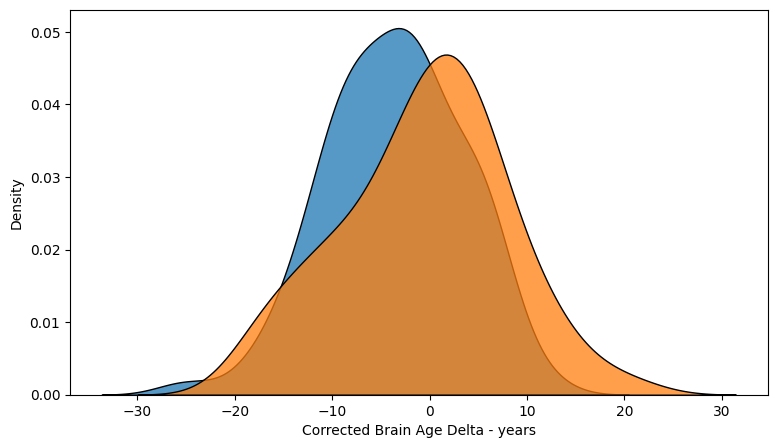

In [118]:
fig_corr = plt.figure(figsize=(9, 5))
kd1 = sns.kdeplot(correction_nw_df, x='corr_res', multiple='stack', label='NW')
kd2 = sns.kdeplot(correction_ob_df, x='corr_res', multiple='stack', label='OB')
plt.xlabel('Corrected Brain Age Delta - years')
fig_corr.savefig('kde_all_inter.png', dpi=600)

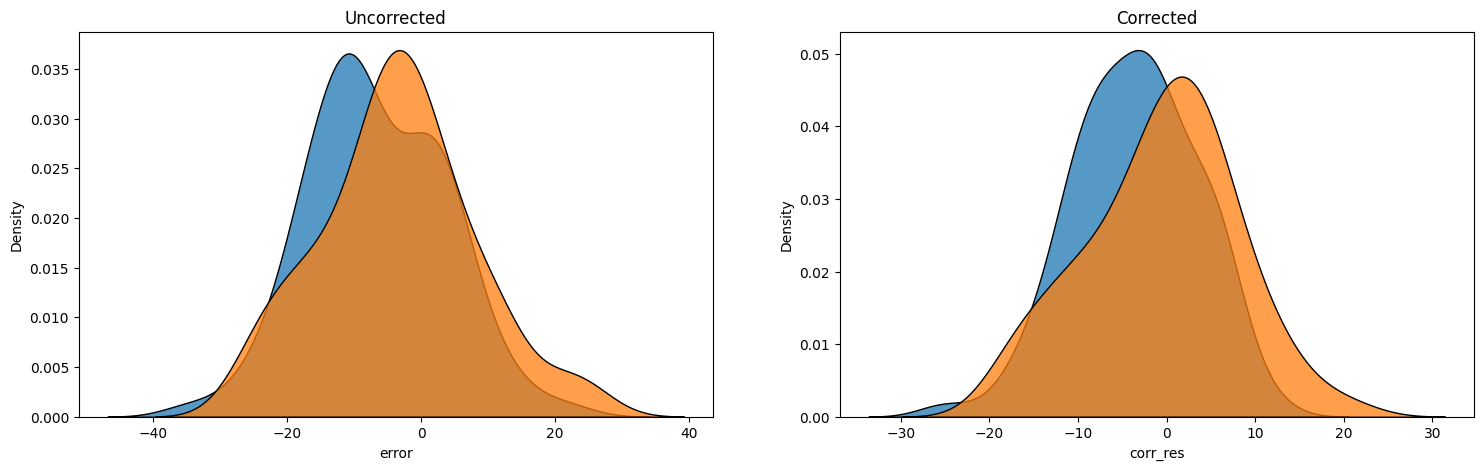

In [119]:
fig10, axes = plt.subplots(ncols=2, figsize=(18, 5))
kd1 = sns.kdeplot(test_ss_df, x='error', multiple='stack', label='NW', ax=axes[0])
kd2 = sns.kdeplot(ob_df, x='error', multiple='stack', label='OB', ax=axes[0])
kd1 = sns.kdeplot(correction_nw_df, x='corr_res', multiple='stack', label='NW', ax=axes[1])
kd2 = sns.kdeplot(correction_ob_df, x='corr_res', multiple='stack', label='OB', ax=axes[1])
axes[0].title.set_text('Uncorrected')
axes[1].title.set_text('Corrected')

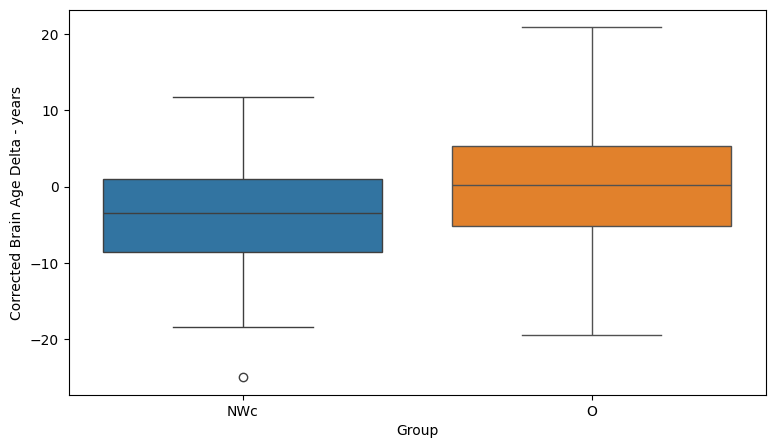

In [120]:
fig_cor2 = plt.figure(figsize=(9, 5))
sns.boxplot(data=correction_nw_df, x='group', y='corr_res')
sns.boxplot(data=correction_ob_df, x='group', y='corr_res')
plt.xlabel('Group')
plt.ylabel('Corrected Brain Age Delta - years')
fig_cor2.savefig('box_all_inter.png', dpi=600)

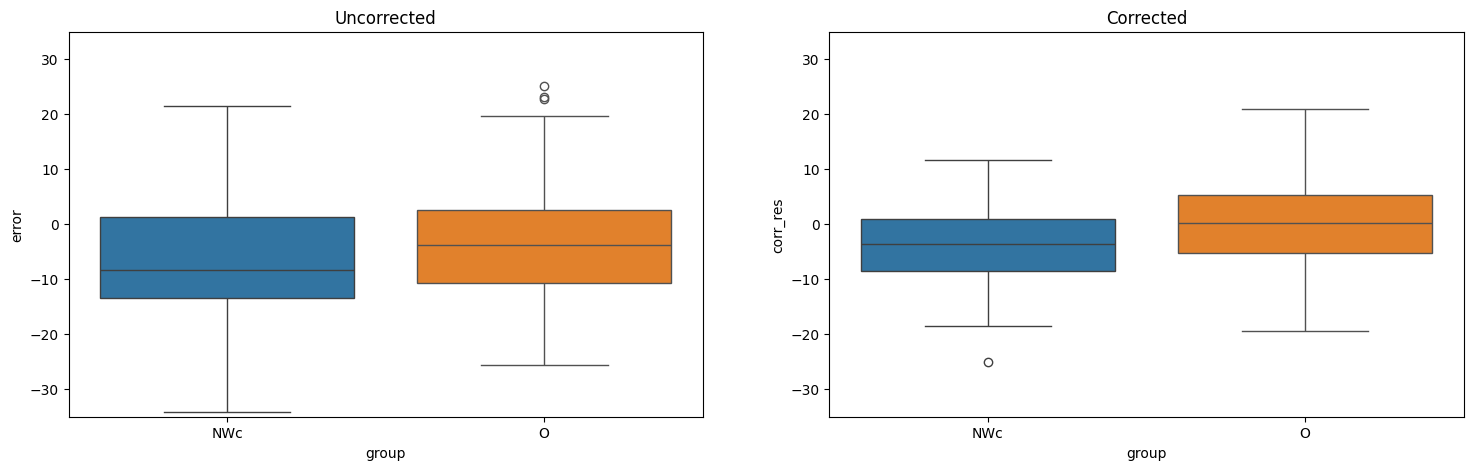

In [121]:
fig11, axes = plt.subplots(ncols=2, figsize=(18, 5))
sns.boxplot(data=test_ss_df, x='group', y='error', ax=axes[0])
sns.boxplot(data=ob_df, x='group', y='error', ax=axes[0])
sns.boxplot(data=correction_nw_df, x='group', y='corr_res', ax=axes[1])
sns.boxplot(data=correction_ob_df, x='group', y='corr_res', ax=axes[1])
axes[0].set_ylim(-35, 35)
axes[1].set_ylim(-35, 35)
axes[0].title.set_text('Uncorrected')
axes[1].title.set_text('Corrected')

In [122]:
bins = [18, 40, 60, 90]

<Figure size 1800x500 with 0 Axes>

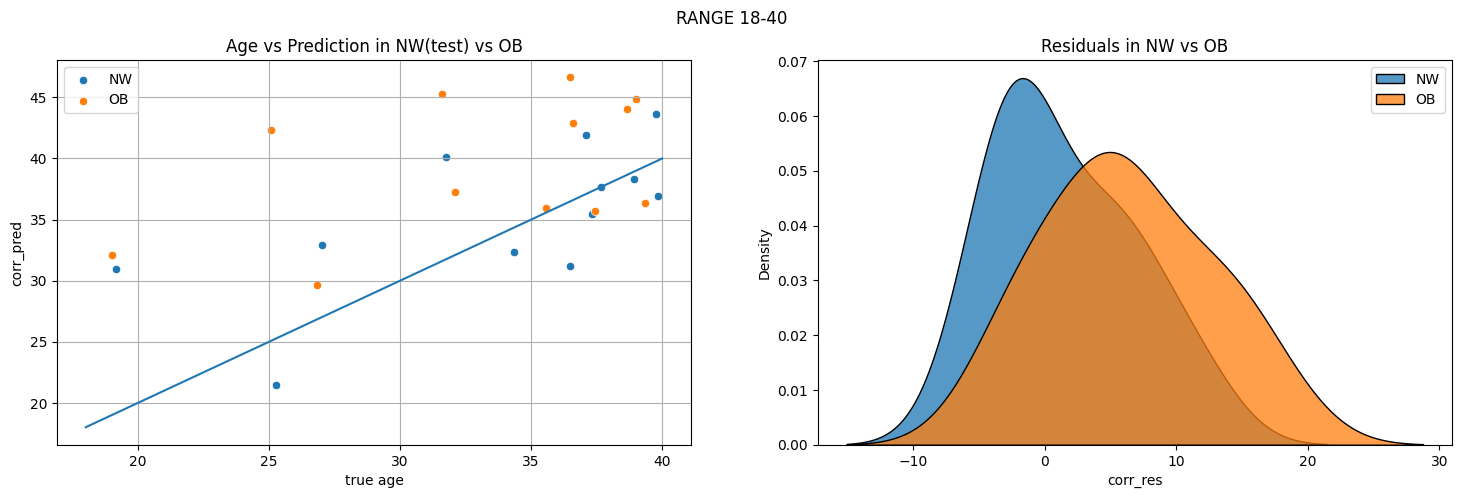

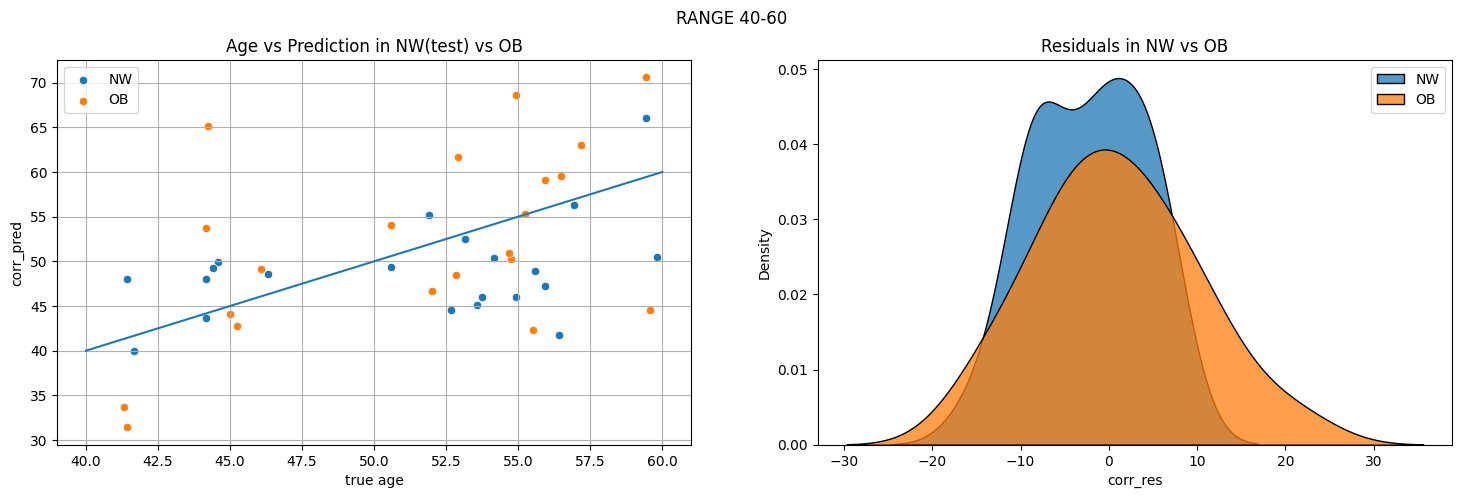

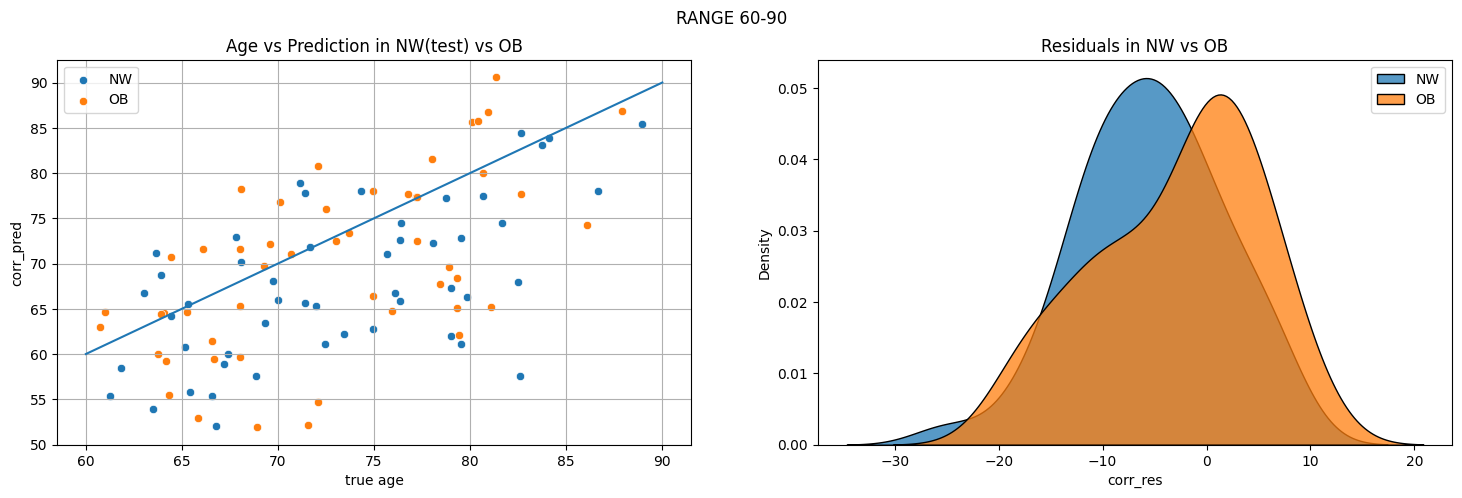

In [123]:
fig11 = plt.figure(layout='constrained', figsize=(18, 5))
subfig = fig11.subfigures(len(bins) - 1, 1)
small_df = [correction_ob_df]
labels_df = ['OB']
for bin_id in range(len(bins) - 1):
    subfig[bin_id], axes = plt.subplots(ncols=2, figsize=(18, 5))
    subfig[bin_id].suptitle('RANGE ' + str(bins[bin_id]) + '-' + str(bins[bin_id + 1]))
    dataf_bin = small_df[0]
    test_bin_df = correction_nw_df[
        (bins[bin_id] < test_ss_df['true age']) & (test_ss_df['true age'] < bins[bin_id + 1])]
    dfi_bin = dataf_bin[(bins[bin_id] <= dataf_bin['true age']) & (dataf_bin['true age'] < bins[bin_id + 1])]
    sc1 = sns.scatterplot(test_bin_df, x='true age', y='corr_pred', ax=axes[0], label='NW')
    sc2 = sns.scatterplot(dfi_bin, x='true age', y='corr_pred', ax=axes[0], label=labels_df[0])
    sns.lineplot(x=[bins[bin_id], bins[bin_id + 1]], y=[bins[bin_id], bins[bin_id + 1]], ax=axes[0])
    kd1 = sns.kdeplot(test_bin_df, x='corr_res', ax=axes[1], multiple='stack', label='NW')
    kd2 = sns.kdeplot(dfi_bin, x='corr_res', ax=axes[1], multiple='stack', label=labels_df[0])
    axes[0].title.set_text('Age vs Prediction in NW(test) vs ' + labels_df[0])
    axes[1].title.set_text('Residuals in NW vs ' + labels_df[0])
    axes[0].legend()
    axes[1].legend()
    axes[0].grid()

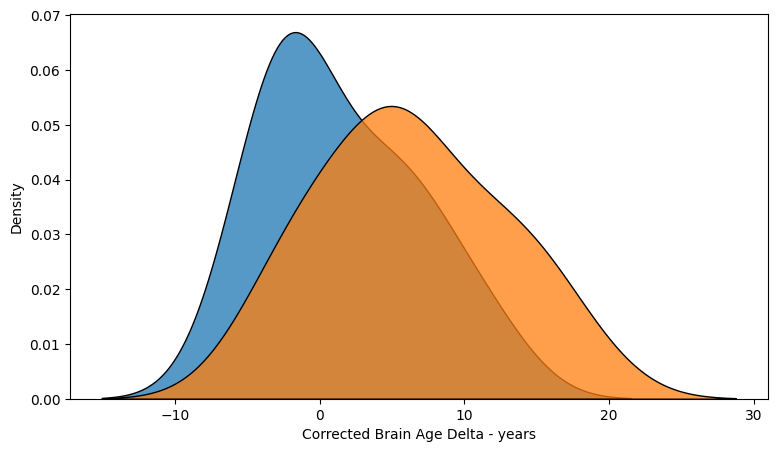

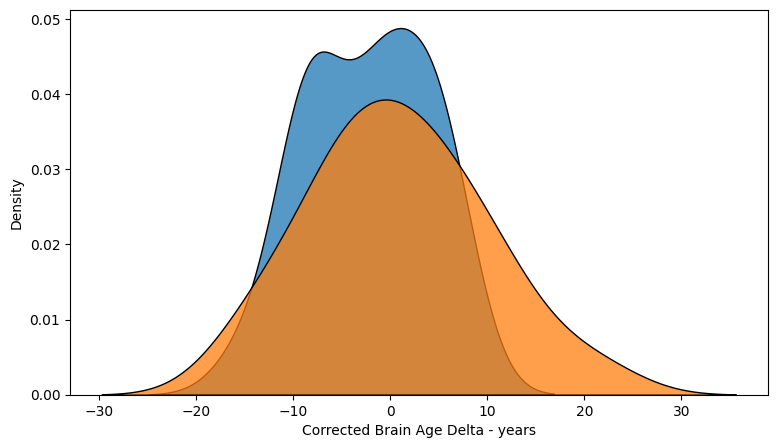

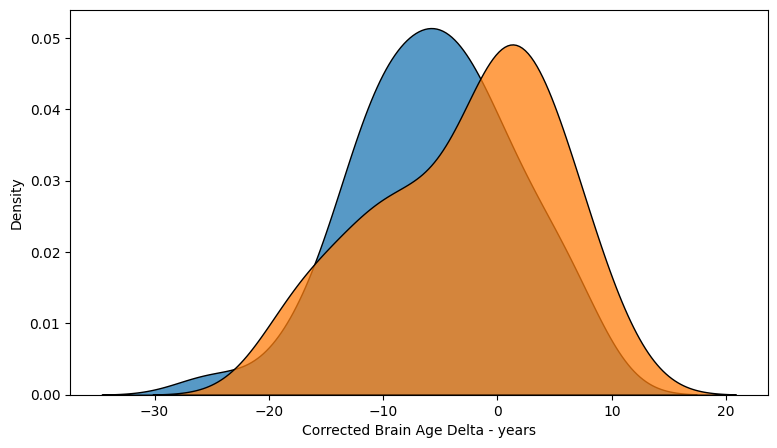

In [124]:
for bin_id in range(len(bins) - 1):
    corr_fig3 = plt.figure(figsize=(9, 5))
    corr_test_bin_df = correction_nw_df[
        (bins[bin_id] < correction_nw_df['true age']) & (correction_nw_df['true age'] < bins[bin_id + 1])]
    corr_ob_bin = correction_ob_df[
        (bins[bin_id] <= correction_ob_df['true age']) & (correction_ob_df['true age'] < bins[bin_id + 1])]
    kd1 = sns.kdeplot(corr_test_bin_df, x='corr_res', multiple='stack', label='NW')
    kd2 = sns.kdeplot(corr_ob_bin, x='corr_res', multiple='stack', label='O')
    plt.xlabel('Corrected Brain Age Delta - years')
    corr_fig3.savefig('kde_inter' + str(bin_id) + '.png', dpi=600)

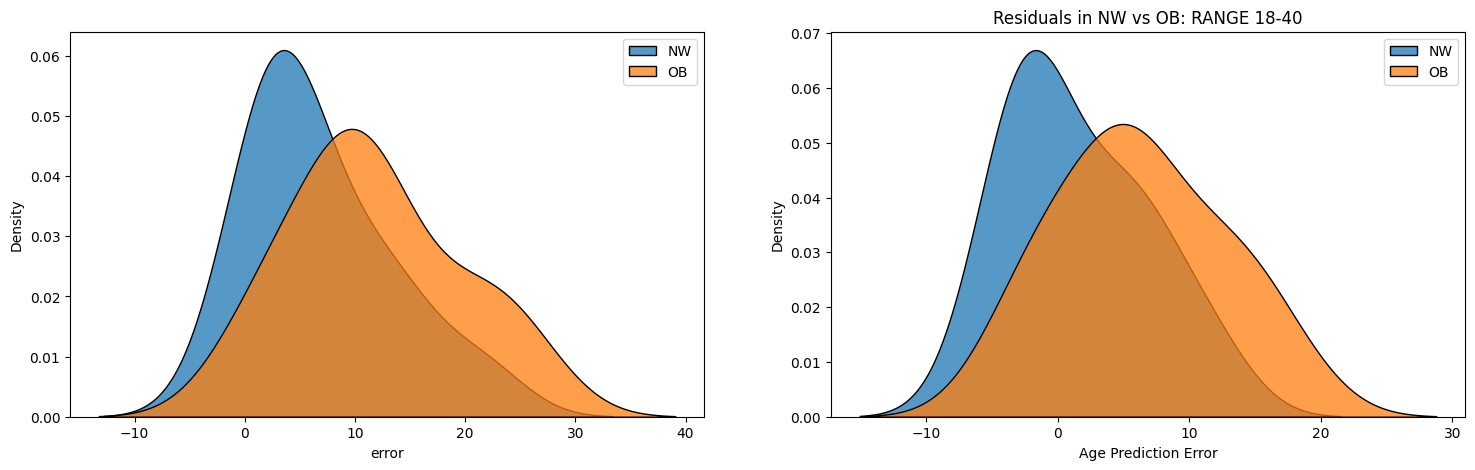

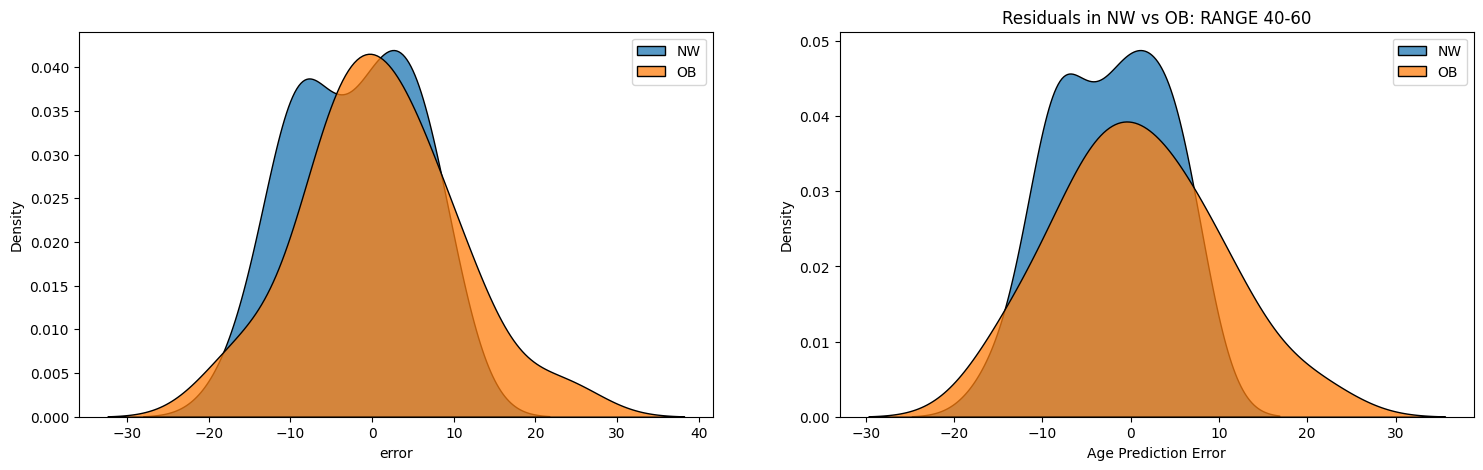

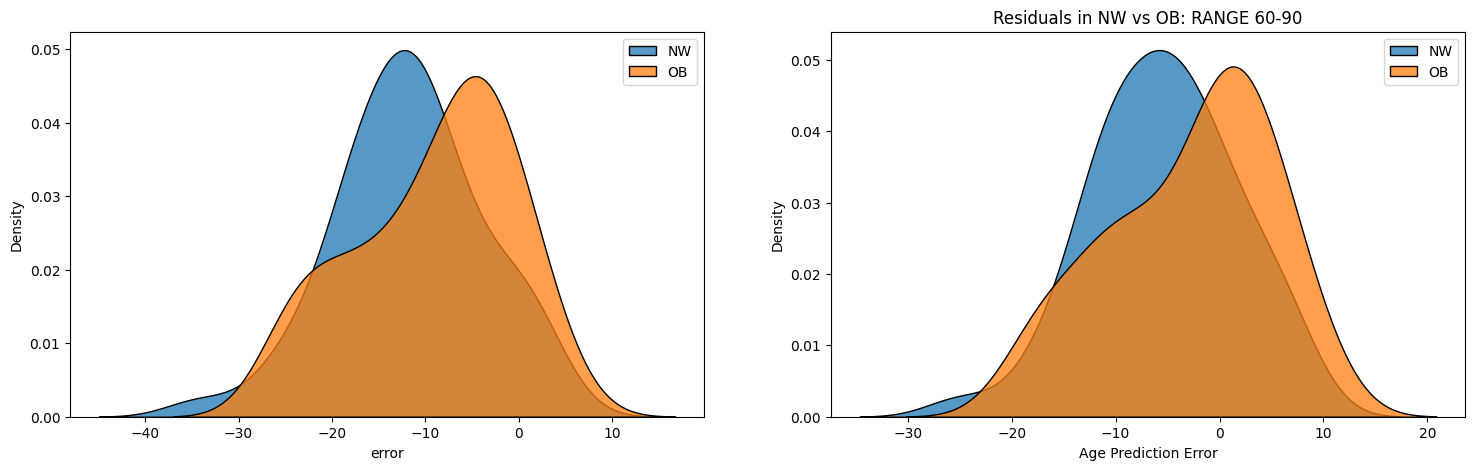

In [125]:
small_df = [ob_df]
labels_df = ['OB']
for bin_id in range(len(bins) - 1):
    fig1, axes = plt.subplots(ncols=2, figsize=(18, 5))
    plt.title('Residuals in NW vs ' + labels_df[0] + ': RANGE ' + str(bins[bin_id]) + '-' + str(bins[bin_id + 1]))
    dataf_bin = small_df[0]
    test_bin_df = test_ss_df[(bins[bin_id] < test_ss_df['true age']) & (test_ss_df['true age'] < bins[bin_id + 1])]
    corr_test_bin_df = correction_nw_df[
        (bins[bin_id] < correction_nw_df['true age']) & (correction_nw_df['true age'] < bins[bin_id + 1])]
    dfi_bin = dataf_bin[(bins[bin_id] <= dataf_bin['true age']) & (dataf_bin['true age'] < bins[bin_id + 1])]
    corr_ob_bin = correction_ob_df[
        (bins[bin_id] <= correction_ob_df['true age']) & (correction_ob_df['true age'] < bins[bin_id + 1])]
    kd1 = sns.kdeplot(test_bin_df, x='error', multiple='stack', label='NW', ax=axes[0])
    kd2 = sns.kdeplot(dfi_bin, x='error', multiple='stack', label=labels_df[0], ax=axes[0])
    kd1 = sns.kdeplot(corr_test_bin_df, x='corr_res', multiple='stack', label='NW', ax=axes[1])
    kd2 = sns.kdeplot(corr_ob_bin, x='corr_res', multiple='stack', label=labels_df[0], ax=axes[1])
    plt.xlabel('Age Prediction Error')
    axes[0].legend()
    axes[1].legend()
    plt.show()

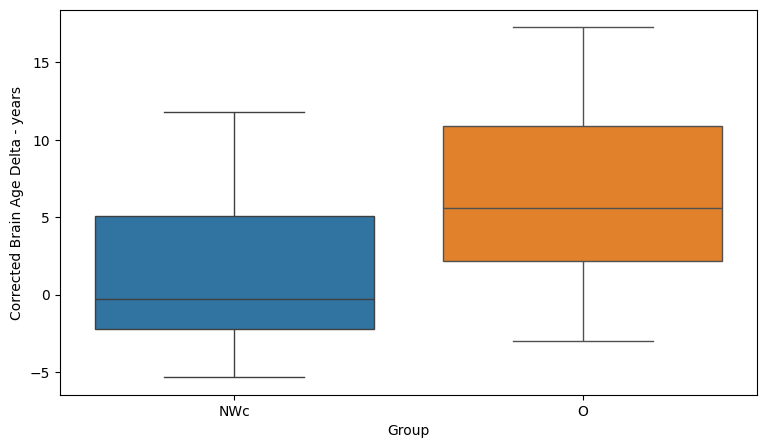

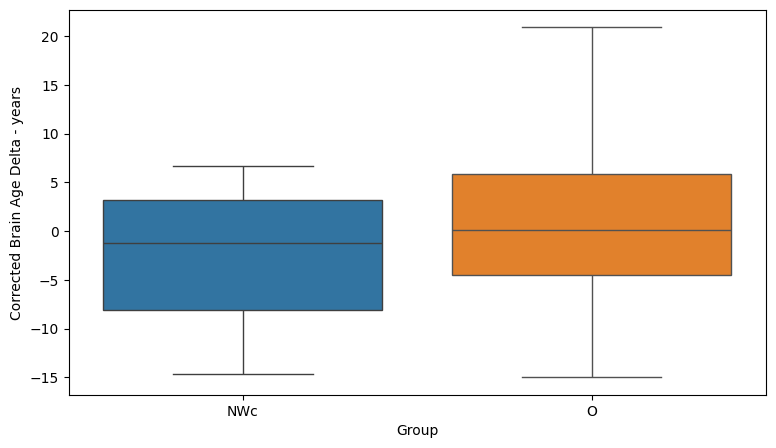

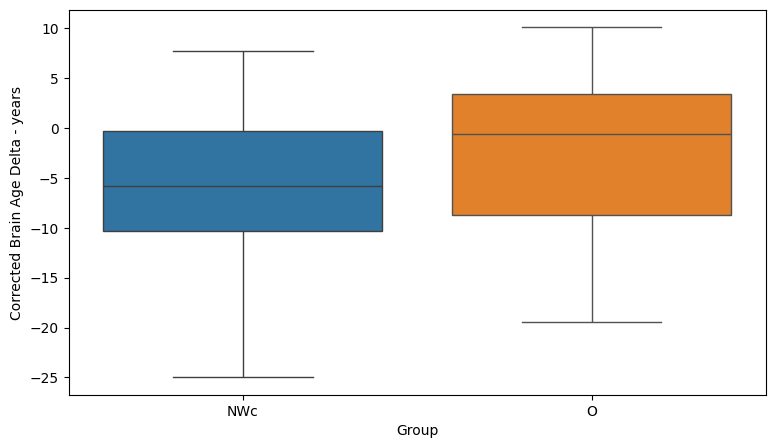

In [126]:
for bin_id in range(len(bins) - 1):
    corr_fig3 = plt.figure(figsize=(9, 5))
    corr_test_bin_df = correction_nw_df[
        (bins[bin_id] < correction_nw_df['true age']) & (correction_nw_df['true age'] < bins[bin_id + 1])]
    corr_ob_bin = correction_ob_df[
        (bins[bin_id] <= correction_ob_df['true age']) & (correction_ob_df['true age'] < bins[bin_id + 1])]
    kd1 = sns.boxplot(corr_test_bin_df, x='group', y='corr_res')
    kd2 = sns.boxplot(corr_ob_bin, x='group', y='corr_res')
    plt.xlabel('Group')
    plt.ylabel('Corrected Brain Age Delta - years')
    corr_fig3.savefig('box_inter_' + str(bin_id) + '.png', dpi=600)

In [127]:
bigplot = plt.figure(figsize=(30,20))
bigplot.show()

<Figure size 3000x2000 with 0 Axes>

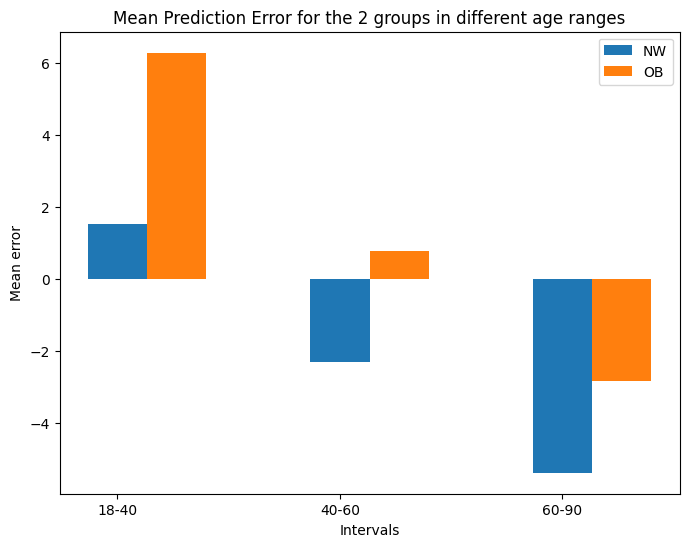

In [128]:
barfig = plt.figure(figsize=(8, 6))
labels_df = ['NW', 'OB']
inter = np.arange(len(intervals)) * 3
for lab in range(len(labels_df)):
    plt.bar(inter + lab * 0.8, corr_dataf_means[lab], label=labels_df[lab])
plt.xticks(inter, intervals)
plt.xlabel("Intervals")
plt.ylabel("Mean error")
plt.title("Mean Prediction Error for the 2 groups in different age ranges")
plt.legend()
plt.show()

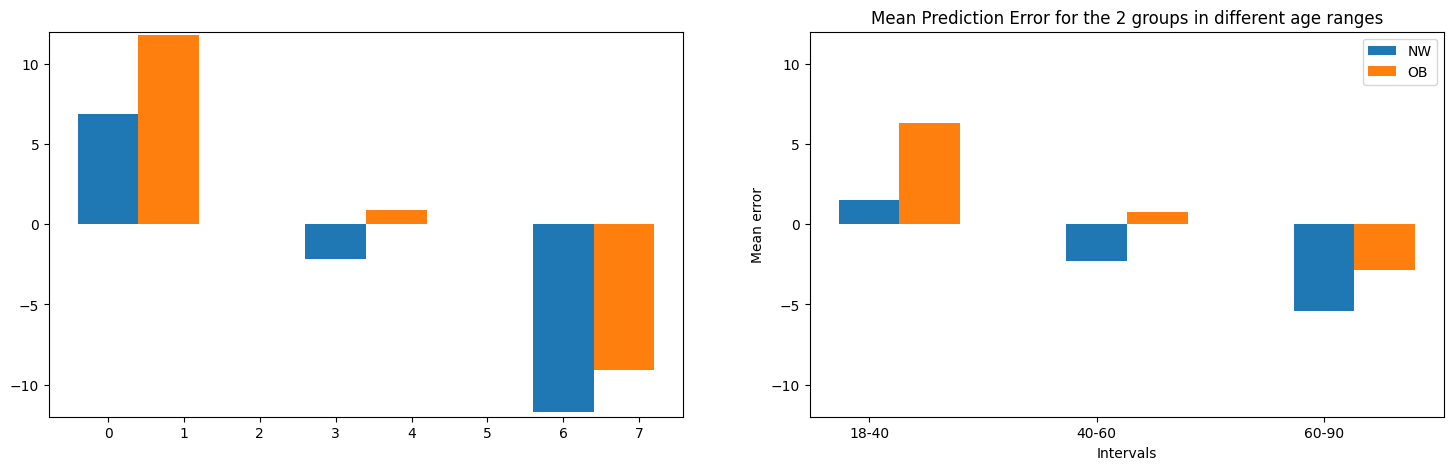

In [129]:
barfig, axes = plt.subplots(ncols=2, figsize=(18, 5))
labels_df = ['NW', 'OB']
inter = np.arange(len(intervals)) * 3
for lab in range(len(labels_df)):
    axes[0].bar(inter + lab * 0.8, dataf_means[lab], label=labels_df[lab])
    axes[1].bar(inter + lab * 0.8, corr_dataf_means[lab], label=labels_df[lab])
axes[0].set_ylim(-12, 12)
axes[1].set_ylim(-12, 12)
plt.xticks(inter, intervals)
plt.xlabel("Intervals")
plt.ylabel("Mean error")
plt.title("Mean Prediction Error for the 2 groups in different age ranges")
plt.legend()
plt.show()

###Bootstrap

In [132]:
import random
from sklearn.utils import resample

In [133]:
n_bs_iterations = 1000
nw_bs_results = []
ob_bs_results = []
res_mae_nw  = []
res_mae_ob = []
features_bs_models = []
train_sample = data_used[nw_sow_train_index]
pca = PCA(n_components=n_comp, svd_solver='auto')
encoded_samples_reduced_PCA = pca.fit_transform(train_sample)
print('pca components shape:', encoded_samples_reduced_PCA.shape)
for bs_it in range(n_bs_iterations):
  print(bs_it)
  res_pca_index = resample(np.arange(len(encoded_samples_reduced_PCA)), replace=True, n_samples=len(encoded_samples_reduced_PCA), random_state=bs_it)
  #res_train_index = resample(nw_sow_train_index, replace=True, n_samples=len(nw_sow_train_index), random_state=bs_it) #index of the resampled train
  res_train_index = nw_sow_train_index[res_pca_index]
  res_x_test = (pca.transform(data_used[norm_test.index]) - np.mean(encoded_samples_reduced_PCA)) / np.std(
    encoded_samples_reduced_PCA)
  res_x_train = (encoded_samples_reduced_PCA[res_pca_index] -
                 np.mean(encoded_samples_reduced_PCA[res_pca_index])) / np.std(encoded_samples_reduced_PCA[res_pca_index])
  res_norm_ob_values = (pca.transform(data_used[obese_ss.index]) -
                        np.mean(encoded_samples_reduced_PCA[res_pca_index])) / np.std(encoded_samples_reduced_PCA[res_pca_index])

  res_train_age = data.Age[res_train_index]
  res_y_test = (data.Age[norm_test.index]- np.mean(res_train_age))/np.std(res_train_age)
  res_y_train = (res_train_age - np.mean(res_train_age))/np.std(res_train_age)
  res_norm_ob_age = (ob_age - np.mean(res_train_age))/np.std(res_train_age)

  bs_model = ElasticNet(alpha=best_parameters['alpha'], l1_ratio=best_parameters['l1_ratio'], random_state=bs_it)
  bs_model.fit(res_x_train, res_y_train)

  res_train_pred = bs_model.predict(res_x_train)*np.std(res_train_age) + np.mean(res_train_age)
  res_test_pred = bs_model.predict(res_x_test)*np.std(res_train_age) + np.mean(res_train_age)
  res_ob_pred = bs_model.predict(res_norm_ob_values)*np.std(res_train_age) + np.mean(res_train_age)
  features_bs_models.append(bs_model.coef_)

  res_df = pd.DataFrame({'true age': res_train_age, 'error': res_train_pred-res_train_age})
  b0,b1 = px.get_trendline_results(px.scatter(res_df, x='true age', y='error',
                                              trendline="ols",)).px_fit_results.iloc[0].params

  res_corr_tr = res_train_pred - (b1*res_train_age + b0)
  res_corr_nw = res_test_pred  - (b1*data.Age[norm_test.index] + b0)
  res_corr_ob = res_ob_pred - (b1*ob_age + b0)
  res_corr_err_tr = res_corr_tr - res_train_age
  res_corr_err_nw = res_corr_nw - data.Age[norm_test.index]
  res_corr_err_ob = res_corr_ob - ob_age

  nw_bs_results.append(metrics.r2_score(data.Age[norm_test.index], res_corr_nw))
  ob_bs_results.append(metrics.r2_score(ob_age, res_corr_ob))
  res_mae_nw.append(np.abs(res_corr_err_nw).mean())
  res_mae_ob.append(np.abs(res_corr_err_ob).mean())
feat_bs = np.array(features_bs_models)

pca components shape: (361, 205)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
2

In [134]:
res_test_pred.shape

(83,)

In [135]:
pd.DataFrame(feat_bs).to_excel('feat_bs_intercon.xlsx')

In [136]:
np.percentile(feat_bs[0], 0)

np.float64(-0.13706693773184564)

<Axes: ylabel='Count'>

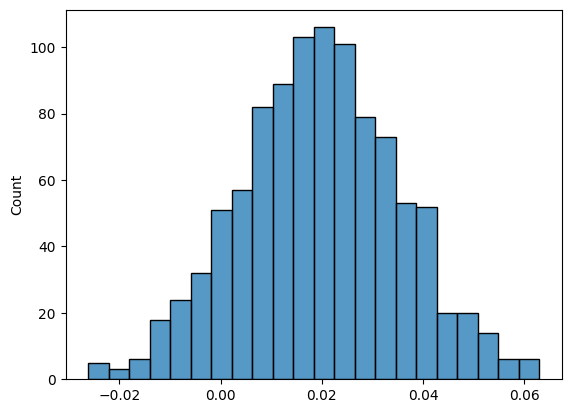

In [137]:
sns.histplot(feat_bs[:,4])

In [138]:
print('NW R2:', np.mean(nw_bs_results), '±', np.std(nw_bs_results))
print('O R2:', np.mean(ob_bs_results), '±', np.std(ob_bs_results))
print('NW MAE:', np.mean(res_mae_nw), '±', np.std(res_mae_nw))
print('O MAE:', np.mean(res_mae_ob), '±', np.std(res_mae_ob))

NW R2: 0.6635332559374812 ± 0.03430252228611906
O R2: 0.6451669692747846 ± 0.0347919514598179
NW MAE: 7.5784618318273385 ± 0.45179487941498825
O MAE: 7.524086861969122 ± 0.3743960786152055


<Axes: ylabel='Count'>

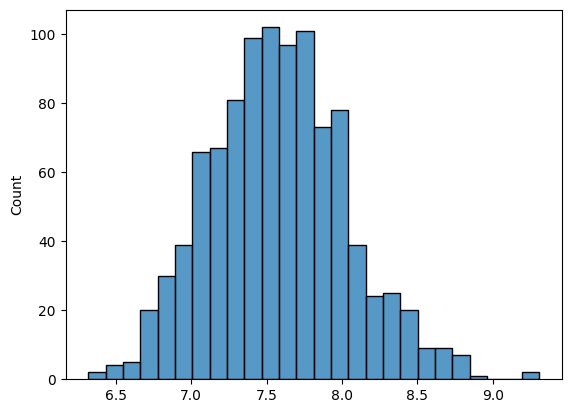

In [139]:
sns.histplot(res_mae_nw)

<Axes: ylabel='Count'>

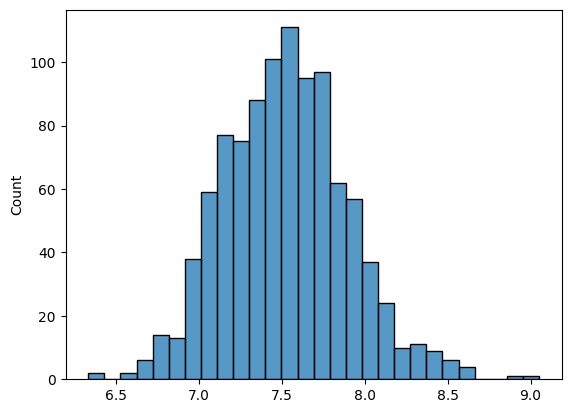

In [140]:
sns.histplot(res_mae_ob)

<Axes: ylabel='Count'>

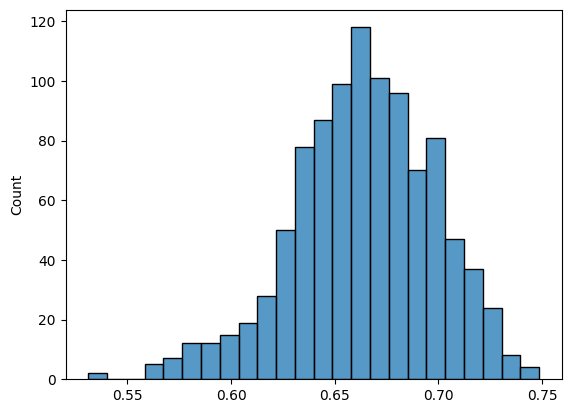

In [141]:
sns.histplot(nw_bs_results)

<Axes: ylabel='Count'>

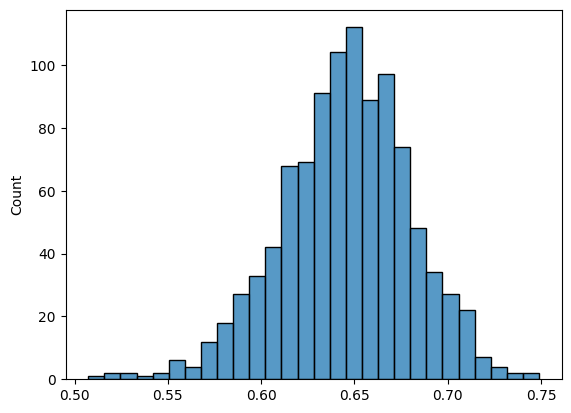

In [142]:
sns.histplot(ob_bs_results)

In [143]:
print('LOWER BOUNDS: \n')
lower_bounds = np.percentile(feat_bs, 2.5, axis=0)
print(lower_bounds.round(5))
print('\n \n UPPER BOUNDS: \n')
upper_bounds = np.percentile(feat_bs, 97.5, axis=0)
print(upper_bounds.round(5))
mean_weights = feat_bs.mean(axis=0)
print('\n \n MEAN WEIGHTS: \n')
print(mean_weights.round(5))

LOWER BOUNDS: 

[-0.02847  0.09472 -0.12568  0.10943 -0.01209 -0.04961 -0.12566  0.06743
  0.07031 -0.16185  0.01878 -0.06317  0.07998 -0.05702 -0.06726 -0.07115
 -0.01301  0.04456 -0.03143 -0.01943  0.01288 -0.03491 -0.0125  -0.0334
  0.03003 -0.11343 -0.01224 -0.01102 -0.11161  0.00365 -0.06157  0.00245
 -0.04728 -0.00189 -0.07215 -0.02882 -0.06878 -0.07811 -0.06004 -0.05068
 -0.01844 -0.09522 -0.03012 -0.03192 -0.01949 -0.01876 -0.04233 -0.03526
 -0.07258  0.03046 -0.05944 -0.1003  -0.04735 -0.04731 -0.04352  0.03452
 -0.06392 -0.04671 -0.01886 -0.01235 -0.05155  0.00051 -0.02658 -0.0376
 -0.02079 -0.02903 -0.02599 -0.06854 -0.07037 -0.06967 -0.00234 -0.01749
  0.0213  -0.15813 -0.03039 -0.05937 -0.0345  -0.05823 -0.09024 -0.05647
 -0.10048 -0.05601 -0.08563 -0.04939 -0.01989 -0.02342 -0.10378 -0.04424
 -0.03605 -0.00034  0.0398  -0.06809 -0.07702 -0.05111 -0.07834 -0.02268
 -0.05282 -0.05045 -0.02871 -0.04139 -0.04746 -0.08997 -0.00209 -0.13405
 -0.08667 -0.05541 -0.07384 -0.07135 

In [144]:
ci_df = pd.DataFrame({'lower': lower_bounds, 'upper': upper_bounds, 'mean': mean_weights})
ci_df

lower     upper      mean
0   -0.028468 -0.014970 -0.021629
1    0.094715  0.130362  0.111472
2   -0.125679 -0.076781 -0.100743
3    0.109431  0.164596  0.136722
4   -0.012085  0.050855  0.019514
..        ...       ...       ...
200 -0.033005  0.042991  0.004644
201 -0.056093  0.028973 -0.013753
202 -0.020162  0.060114  0.018743
203 -0.023783  0.051199  0.011140
204 -0.041764  0.042965  0.000792

[205 rows x 3 columns]

In [149]:
ci_df[(ci_df['lower'] <=0) != (ci_df['upper']>=0) ]

lower     upper      mean
0   -0.028468 -0.014970 -0.021629
1    0.094715  0.130362  0.111472
2   -0.125679 -0.076781 -0.100743
3    0.109431  0.164596  0.136722
6   -0.125661 -0.063895 -0.094146
7    0.067426  0.133829  0.101593
8    0.070310  0.134803  0.101138
9   -0.161854 -0.087880 -0.124912
10   0.018778  0.091793  0.055661
12   0.079981  0.149980  0.116025
17   0.044556  0.122056  0.086407
20   0.012883  0.090904  0.050993
24   0.030026  0.117210  0.074311
25  -0.113430 -0.032394 -0.073788
28  -0.111606 -0.028710 -0.069780
29   0.003651  0.082176  0.041601
31   0.002454  0.081169  0.041450
41  -0.095222 -0.008745 -0.052846
49   0.030461  0.110732  0.070188
51  -0.100299 -0.010355 -0.057602
55   0.034525  0.121002  0.077607
61   0.000512  0.088637  0.045273
72   0.021296  0.117175  0.068838
73  -0.158127 -0.068664 -0.114374
78  -0.090243 -0.002868 -0.046859
80  -0.100484 -0.014243 -0.057177
86  -0.103778 -0.009244 -0.059811
90   0.039798  0.125042  0.083105
103 -0.134053 -0.039616 -0.089127
129  0.000453  0.090511  0.045665
130 -0.093148 -0.004613 -0.047925
135 -0.104018 -0.010644 -0.059311
136 -0.091763 -0.007770 -0.050874
144  0.017023  0.102777  0.060085
148 -0.110021 -0.012969 -0.060835
153  0.003722  0.096712  0.049585
160 -0.093620 -0.009710 -0.052306
165 -0.090097 -0.005981 -0.048401
177 -0.094391 -0.006526 -0.049048
190 -0.087365 -0.008327 -0.049300
194 -0.082050 -0.001741 -0.040055

###Permutation

In [150]:
import random

In [200]:
n_permutations = 1000
perm_nw_r2 = []
perm_ob_r2 = []
perm_nw_mae = []
perm_ob_mae = []
y_train_shuffled = np.copy(y_train)
for perm in range(n_permutations):
  random.seed(perm)
  random.shuffle(y_train_shuffled)
  perm_model = ElasticNet(alpha=best_parameters['alpha'], l1_ratio=best_parameters['l1_ratio'], random_state=perm)
  perm_model.fit(x_train, y_train_shuffled)

  perm_train_pred = perm_model.predict(x_train)*np.std(train_age) + np.mean(train_age)
  perm_test_pred = perm_model.predict(x_test)*np.std(train_age) + np.mean(train_age)
  perm_ob_pred = perm_model.predict(norm_ob_values)*np.std(train_age) + np.mean(train_age)
  perm_nw_r2.append(metrics.r2_score(test_ss_df['true age'], perm_test_pred))
  perm_ob_r2.append(metrics.r2_score(ob_age, perm_ob_pred))
  perm_nw_mae.append(np.abs(perm_test_pred-test_ss_df['true age']).mean())
  perm_ob_mae.append(np.abs(perm_ob_pred-ob_age).mean())
  perm_train_age = y_train_shuffled*np.std(train_age) + np.mean(train_age)
  perm_df = pd.DataFrame({'true age': perm_train_age, 'error': perm_train_pred-perm_train_age})

In [201]:
results_perm_df = pd.DataFrame({'R2_nw': perm_nw_r2, 'MAE_nw' : perm_nw_mae,
                                'R2_ob': perm_ob_r2, 'MAE_ob': perm_ob_mae})
results_perm_df

R2_nw     MAE_nw     R2_ob     MAE_ob
0   -0.520452  16.974698 -0.374222  16.262544
1   -0.434405  16.780058 -0.354436  16.154527
2   -0.491655  17.015722 -0.529717  17.089336
3   -0.607305  17.566491 -0.762119  18.621830
4   -0.442403  16.439868 -0.684557  17.852666
..        ...        ...       ...        ...
995 -0.483526  17.018105 -0.458955  16.664172
996 -0.657958  18.367951 -0.571518  17.084554
997 -0.465005  16.491472 -0.328075  15.809420
998 -0.713033  18.246699 -0.494006  16.819697
999 -0.429082  17.005793 -0.208877  15.332578

[1000 rows x 4 columns]

In [202]:
print('NW R2:', np.mean(perm_nw_r2), '±', np.std(perm_nw_r2))
print('O R2:', np.mean(perm_ob_r2), '±', np.std(perm_ob_r2))
print('NW MAE:', np.mean(perm_nw_mae), '±', np.std(perm_nw_mae))
print('O MAE:', np.mean(perm_ob_mae), '±', np.std(perm_ob_mae))

NW R2: -0.5411093829817869 ± 0.14679459756943417
O R2: -0.517375575735234 ± 0.16667579039300953
NW MAE: 17.27393078041781 ± 0.8843768652476047
O MAE: 17.126457922760775 ± 0.9826710571414938


In [203]:
results_perm_df.to_excel('results_intra_perm_test.xlsx')

In [204]:
print(x_train.mean())
print(x_train.std())

2.640352034781806e-18
1.0


In [205]:
print('p-value null model outperforms the original model (NW, R-squred):', np.sum(np.array(perm_nw_r2)>=nw_score)/n_permutations*100, '%')
print('p-value null model outperforms the original model (O, R-squared):', np.sum(np.array(perm_ob_r2)>=ob_score)/n_permutations*100, '%')
print('p-value model null outperforms the original model (NW, MAE):', np.sum(np.array(perm_nw_mae)<=nw_mae)/n_permutations*100, '%')
print('p-value model null outperforms the original model (O, MAE):', np.sum(np.array(perm_ob_mae)<=mae_ob)/n_permutations*100, '%')

p-value null model outperforms the original model (NW, R-squred): 0.0 %
p-value null model outperforms the original model (O, R-squared): 0.0 %
p-value model null outperforms the original model (NW, MAE): 0.0 %
p-value model null outperforms the original model (O, MAE): 0.0 %


#Classification

MRI-derived measures yielding significant differences in age prediction error (both inter- and intra-connectivity) between O and NWc were also used to train models for classification of the obesity status.

In this second part, the number of PCs used for intra- and inter-connectivity corresponded to those explaining 95% of the variance in the training set. We used logistic regression as classifier, provided by the LogisticRegression class in scikit-learn.

In [167]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn import metrics

In [168]:
balanced = True  # True False
if balanced:
    norm_ob_index = np.concatenate((norm_test.index, obese_ss.index))
    print(norm_ob_index.shape)
else:
    norm_ob_index = np.concatenate((norm_weight_ss.index, obese_ss.index))
    print(norm_ob_index.shape)

(166,)


In [169]:
norm_ob_data = data.loc[norm_ob_index]
norm_ob_label = norm_ob_data.Group
norm_ob_ages = norm_ob_data.Age.values
norm_ob_gender = norm_ob_data.Sex.values

In [170]:
final_labels = []
for i in range(len(norm_ob_label)):
    if norm_ob_label.iloc[i] == 1:
        final_labels.append(0)
    else:
        final_labels.append(1)
final_labels = np.array(final_labels)

In [171]:
data_used = type_data[1]  #1 = inter; 2 = intra
data_used.shape

(535, 12322)

Area under the curve (AUC), sensitivity (SE) and specificity (SP) were utilized to evaluate the predictive performance of the different models.

This was done using the following implemented function (calculate_metrics).

In [172]:
from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix

In [173]:
def calculate_metrics(y_true, y_pred_prob):
    # Convert probabilities to binary predictions based on the threshold
    fpr, tpr, threshold = metrics.roc_curve(y_true, y_pred_prob)
    difference_tpr_fpr = tpr - fpr  ##jouden j statistics is a statistic that captures the performance of a dichotomous diagnostic test
    optimal_threshold = threshold[np.argmax(difference_tpr_fpr)]
    y_pred = (y_pred_prob >= optimal_threshold).astype(int)

    # Calculate AUC
    auc = metrics.auc(fpr, tpr)
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()

    # Compute sensitivity (TPR) and specificity (1 - FPR)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    return auc, sensitivity, specificity

In [174]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

In [175]:
final_labels[norm_ob_ages < 40].shape

(24,)

In [176]:
train_for_pca = data_used[norm_ob_index]
pca = PCA(n_components=.95, svd_solver='auto')  #95,90,85
encoded_samples_reduced_PCA = pca.fit_transform(train_for_pca)
print(encoded_samples_reduced_PCA.shape)

(166, 129)


 The dataset was split into 10 folds with a k-fold cross-validation scheme stratified by age. To ensure more stable results, this process was repeated 10 times using RepeatedStratifiedKFold function.

In [177]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

In [178]:
classifiers = ['XGBClassifier', 'Logistic Regression', 'SVC']
classifier = classifiers[1]
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10)
rskf.get_n_splits(encoded_samples_reduced_PCA, final_labels)
test_preds = np.full(encoded_samples_reduced_PCA.shape[0], np.nan)
results = []
model_coefficients = []
aucs_age_range = [[], [], []]
specificity_age_range = [[], [], []]
sensitivity_age_range = [[], [], []]
for i, (train_index, test_index) in enumerate(rskf.split(encoded_samples_reduced_PCA, final_labels)):
    print(f"Fold {i}:")
    #print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")
    norm_ages = (norm_ob_ages - np.mean(norm_ob_ages[train_index])) / np.std(norm_ob_ages[train_index])
    norm_fmri_values = (encoded_samples_reduced_PCA - np.mean(encoded_samples_reduced_PCA[train_index])) / np.std(
        encoded_samples_reduced_PCA[train_index])
    x_class = np.array(
        [np.concatenate((norm_fmri_values[i, :], np.array([norm_ages[i]]), np.array([norm_ob_gender[i]]))) for i in
         range(norm_fmri_values.shape[0])])
    if classifier == 'Logistic Regression':
        #model = LogisticRegressionCV(cv=10, Cs=np.logspace(-4, 4, num=20), max_iter=2000, class_weight='balanced')
        model = LogisticRegression(max_iter=2000, class_weight='balanced')
        model = GridSearchCV(model, param_grid={'C': np.logspace(-4, 4, num=30),
                                                'tol': [3, 2, 1, 0.5, 0.05, 0.1, 0.01, 0.005, 0.001, 0.0001]},
                             # tol = [3, 2, 1, 0.5, 0.05, 0.005, 0.0001]
                             scoring='neg_log_loss', cv=10, error_score='raise')
        #model = LogisticRegression(
    elif classifier == 'XGBClassifier':
        model = XGBClassifier()  #scale_pos_weight = np.sum(np.array(final_labels)==0)/np.sum(np.array(final_labels)==1))
        model = GridSearchCV(model, param_grid={'n_estimators': [5, 10, 15, 20], 'max_depth': [2, 3, 4, 5, 6, 7],
                                                'learning_rate': [0.05, 0.1, 0.3, 0.5]},
                             scoring='neg_log_loss', cv=10,
                             refit=True)  #scoring: neg_log_loss, n_est: [5,10,15], max_depth: [2,3,4,5,6,7]
    elif classifier == 'SVC':
        model = SVC(kernel='linear', class_weight='balanced', probability=True, max_iter=10000)
        model = GridSearchCV(model, param_grid={'C': np.logspace(-4, 4, num=20), 'tol': [0.01, 0.001, 0.0001]},
                             scoring='neg_log_loss', cv=10)
    else:
        raise ValueError('Wrong classifier')

    model.fit(x_class[train_index], np.array(final_labels)[train_index])
    #model_Cs.append(model.C_)
    #coeffs.append(model.coef_)
    #model_parameters.append(model.get_params())
    test_preds[test_index] = model.predict_proba(x_class[test_index])[:, 1]
    model_coefficients.append(model.best_estimator_.coef_)
    if not np.isnan(test_preds).any():
        auc_0, sensitivity_0, specificity_0 = calculate_metrics(np.array(final_labels), test_preds)
        print('AUC:', auc_0)
        print('Sensitivity:', sensitivity_0)
        print('Specificity:', specificity_0)
        if classifier == 'XGBClassifier':
            print(model.best_params_)
        results.append({'AUC': auc_0,
                        'sensitivity': sensitivity_0,
                        'specificity': specificity_0,
                        'C': model.best_params_['C'],
                        'tol': model.best_params_['tol']
                        })

        age_ranges = [18, 40, 60, 90]
        for age_range_i in range(len(age_ranges) - 1):
            auc_1, sensitivity_1, specificity_1 = calculate_metrics(
                np.array(final_labels)[(norm_ob_ages >= age_ranges[age_range_i])
                                       & (norm_ob_ages < age_ranges[age_range_i + 1])],
                test_preds[(norm_ob_ages >= age_ranges[age_range_i]) & (norm_ob_ages < age_ranges[age_range_i + 1])])
            aucs_age_range[age_range_i].append(auc_1)
            sensitivity_age_range[age_range_i].append(sensitivity_1)
            specificity_age_range[age_range_i].append(specificity_1)
        test_preds = np.full(encoded_samples_reduced_PCA.shape[0], np.nan)

results = pd.DataFrame(results)
print(f'Mean AUC: {results.AUC.mean()}')
print(f'Mean sensitivity: {results.sensitivity.mean()}')
print(f'Mean specificity: {results.specificity.mean()}')

Fold 0:
  Test:  index=[  6   9  27  28  31  35  38  51  63  89  90  95 100 133 148 157 162]
Fold 1:
  Test:  index=[ 11  14  36  37  44  47  54  73  77  85  94 103 110 120 127 135 153]
Fold 2:
  Test:  index=[  4   8  46  56  60  62  65  67  76 121 125 130 138 139 142 150 155]
Fold 3:
  Test:  index=[  0  15  32  42  43  48  52  57  84  87  98 106 107 118 124 136 145]
Fold 4:
  Test:  index=[  2   5  22  40  61  68  70  75 104 108 112 122 128 134 159 160 165]
Fold 5:
  Test:  index=[ 16  20  30  34  59  69  81  82  96 101 113 115 141 152 156 158 161]
Fold 6:
  Test:  index=[  1   7  17  24  49  55  58  72  86  88  93  97 102 105 109 151]
Fold 7:
  Test:  index=[  3  21  23  41  45  50  71  80  92 116 126 140 144 147 149 164]
Fold 8:
  Test:  index=[ 10  12  19  26  33  53  74  79  83  99 111 117 123 131 143 163]
Fold 9:
  Test:  index=[ 13  18  25  29  39  64  66  78  91 114 119 129 132 137 146 154]
AUC: 0.6327478589055016
Sensitivity: 0.4819277108433735
Specificity: 0.783132530120481

In [179]:
results

AUC  sensitivity  specificity         C   tol
0  0.632748     0.481928     0.783133  0.016103  0.10
1  0.588329     0.722892     0.506024  0.016103  0.10
2  0.591523     0.530120     0.674699  0.016103  0.10
3  0.626651     0.650602     0.614458  0.016103  0.10
4  0.629264     0.421687     0.843373  0.008532  0.05
5  0.635070     0.722892     0.530120  0.016103  0.10
6  0.623603     0.530120     0.734940  0.008532  0.10
7  0.628829     0.614458     0.710843  0.016103  0.10
8  0.622296     0.710843     0.554217  0.008532  0.10
9  0.628974     0.722892     0.518072  0.008532  0.10

In [180]:
print('C = (', round(results.C.mean(), 3), '±', round(results.C.std(), 3), ')')
print('tol = (', round(results.tol.mean(), 3), '±', round(results.tol.std(), 3), ')')

C = ( 0.013 ± 0.004 )
tol = ( 0.095 ± 0.016 )


In [181]:
print('AUC mean:', results.AUC.mean())
print('AUC std', results.AUC.std())
print('Sensitivity mean:', results.sensitivity.mean())
print('Sensitivity std', results.sensitivity.std())
print('Specificity mean:', results.specificity.mean())
print('Specificity std', results.specificity.std())

AUC mean: 0.620728697924227
AUC std 0.01668364117017513
Sensitivity mean: 0.6108433734939759
Sensitivity std 0.11288641569874064
Specificity mean: 0.646987951807229
Specificity std 0.11995198041383025


In [182]:
print('Mean AUC 18-40', np.array(aucs_age_range[0]).mean())
print('SD AUC 18_40', np.array(aucs_age_range[0]).std())
print('Mean AUC 40-60', np.array(aucs_age_range[1]).mean())
print('SD AUC 40-60', np.array(aucs_age_range[1]).std())
print('Mean AUC 60-90', np.array(aucs_age_range[2]).mean())
print('SD AUC 60-90', np.array(aucs_age_range[2]).std())

Mean AUC 18-40 0.6131944444444445
SD AUC 18_40 0.059984083537033175
Mean AUC 40-60 0.7730158730158732
SD AUC 40-60 0.025219048989182764
Mean AUC 60-90 0.57828
SD AUC 60-90 0.025399244083239965


In [183]:
print('Mean specificity 18-40', np.array(specificity_age_range[0]).mean())
print('SD specificity 18-40', np.array(specificity_age_range[0]).std())
print('Mean specificity 40-60', np.array(specificity_age_range[1]).mean())
print('SD specificity 40-60', np.array(specificity_age_range[1]).std())
print('Mean specificity 60-90', np.array(specificity_age_range[2]).mean())
print('SD specificity 60-90', np.array(specificity_age_range[2]).std())

Mean specificity 18-40 0.9249999999999998
SD specificity 18-40 0.07861650943380502
Mean specificity 40-60 0.8428571428571429
SD specificity 40-60 0.08793421577437803
Mean specificity 60-90 0.656
SD specificity 60-90 0.063118935352238


In [184]:
print('Mean sensitivity 18-40', np.array(sensitivity_age_range[0]).mean())
print('SD sensitivity 18-40', np.array(sensitivity_age_range[0]).std())
print('Mean sensitivity 40-60', np.array(sensitivity_age_range[1]).mean())
print('SD sensitivity 40-60', np.array(sensitivity_age_range[1]).std())
print('Mean sensitivity 60-90', np.array(sensitivity_age_range[2]).mean())
print('SD sensitivity 60-90', np.array(sensitivity_age_range[2]).std())

Mean sensitivity 18-40 0.45833333333333337
SD sensitivity 18-40 0.11334558757279536
Mean sensitivity 40-60 0.6952380952380952
SD sensitivity 40-60 0.10033955955097845
Mean sensitivity 60-90 0.5760000000000001
SD sensitivity 60-90 0.07735631842325487


##Bootstrap Classification

In [185]:
import random
from sklearn.utils import resample

In [193]:
import numpy as np
from sklearn.linear_model import LogisticRegression

# Assume X and y are your features and target variable.
n_bootstraps = 1000
model_coefficients = []
aucs_age_range = [[], [], []]
specificity_age_range = [[], [], []]
sensitivity_age_range = [[], [], []] # To store the coefficients and other
#performance metrics from each bootstrap sample

for i in range(n_bootstraps):
    print(i)
    # Create a bootstrap sample: sample indices with replacement
    np.random.seed(i)
    sample_indices = np.random.choice(np.arange(final_labels.shape[0]), size=final_labels.shape[0], replace=True) # PLACE SEED
    norm_conn_values = (encoded_samples_reduced_PCA[sample_indices]-np.mean(encoded_samples_reduced_PCA[sample_indices], axis=0))/np.std(encoded_samples_reduced_PCA[sample_indices], axis=None)
    norm_ages = (norm_ob_ages[sample_indices]-np.mean(norm_ob_ages[sample_indices]))/np.std(norm_ob_ages[sample_indices])
    X_boot = np.array([np.concatenate((norm_conn_values[i, :], np.array([norm_ages[i]]), np.array([norm_ob_gender[i]]))) for i in range(norm_conn_values.shape[0])])
    y_boot = final_labels[sample_indices]
    # Fit logistic regression model on the bootstrap sample
    model = LogisticRegression(max_iter=2000, C=1.29,tol=0.011, class_weight= 'balanced', random_state=i)#, C=1.3, tol=0.001, random_state = i,)
    model.fit(X_boot, y_boot)
    # Append the coefficients (assuming binary classification)
    model_coefficients.append(model.coef_[0])
    #model_coefficients.append(np.array(model.best_estimator_.coef_))

# Convert list to a NumPy array for easier manipulation
coefficients = np.array(model_coefficients)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [194]:
norm_bs_coeffs = np.array([(coefficients[:, :-2][i,:]-np.mean(coefficients[:, :-2][i, :]))/np.std(coefficients[:, :-2][i,:]) for i in range(coefficients[:, :-2].shape[0])])
norm_bs_coeffs

array([[-0.32404826, -0.99899317,  1.2926283 , ...,  0.40837605,
        -0.93669486,  0.88468746],
       [-0.22025457, -1.74956277,  0.39177961, ...,  1.47118295,
        -1.15082534,  1.19165143],
       [-0.19936373, -2.10059839,  0.11952684, ..., -0.15852903,
        -1.14969046, -0.03692565],
       ...,
       [-0.08405353, -2.24403437,  0.82441224, ...,  2.14064365,
        -1.08160842,  0.74254462],
       [-0.27094899, -1.8477979 ,  0.6943012 , ...,  0.9572645 ,
        -0.67331121,  0.37468634],
       [-0.27482531, -2.25844047, -0.23708048, ..., -0.01601769,
        -0.56912991,  0.7417278 ]])

In [195]:
norm_bs_coeffs.shape

(1000, 129)

In [196]:
norm_conf_interval = np.nanpercentile(norm_bs_coeffs, [2.5, 97.5], axis=0)
print("95% Confidence Intervals for each coefficient:")
print(norm_conf_interval)

95% Confidence Intervals for each coefficient:
[[-0.55569518 -2.84565491 -0.10981402 -1.3452483  -2.21161155 -0.71274919
  -0.28349234 -1.40809608 -1.01449289 -1.79575971 -1.44551079 -2.02512904
  -3.0088008  -0.01575551 -1.57713264 -1.12776381 -2.01642175 -1.8340726
  -1.26077284 -0.25450803 -1.80018225 -1.15189982 -0.91083802 -0.32777307
  -1.08485923 -1.05887874  0.35436188 -0.29785059 -1.08860714 -1.14286978
  -0.92413765 -0.30994331 -1.34045841 -3.27159855 -2.02982877 -1.27980606
  -1.77098766 -0.68419379 -0.78672114 -1.44438766 -1.43293573 -1.61328946
  -1.45647545 -0.2187837  -1.26911044 -1.09872671 -0.57192932 -0.75503754
  -0.45722341 -0.26803321 -1.5851717  -3.05178593 -1.62356803  0.10704101
  -0.96586129 -2.03111869 -1.99800712 -0.82144992 -0.1240199  -2.79212305
  -1.72872631 -0.03557013 -2.76173687 -1.45561874 -1.33172853 -1.29106695
  -1.30633998 -0.59422795 -1.34646567 -1.9809895  -1.99890305 -1.53445867
  -2.31743835 -0.98458312 -2.00610161 -1.40588375 -0.85303895 -1.2

In [197]:
norm_conf_interval.shape

(2, 129)

In [198]:
norm_ci_df = pd.DataFrame({'lower': norm_conf_interval[0, :], 'upper': norm_conf_interval[1, :],'mean': np.mean(norm_bs_coeffs, axis=0) })
norm_ci_df

lower     upper      mean
0   -0.555695  0.023830 -0.250340
1   -2.845655 -1.161546 -1.921784
2   -0.109814  1.972912  0.840215
3   -1.345248  0.679658 -0.316148
4   -2.211612 -0.133358 -1.181015
..        ...       ...       ...
124 -0.271511  1.947091  0.840867
125  0.020816  2.390424  1.214635
126 -0.852609  1.667069  0.367273
127 -2.696546 -0.026544 -1.411524
128 -0.750847  1.633680  0.395093

[129 rows x 3 columns]

In [199]:
norm_ci_df[((norm_ci_df['lower'] <=0) != (norm_ci_df['upper']>=0))]

lower     upper      mean
1   -2.845655 -1.161546 -1.921784
4   -2.211612 -0.133358 -1.181015
12  -3.008801 -0.732663 -1.832254
26   0.354362  2.738970  1.584793
33  -3.271599 -0.660304 -2.000516
51  -3.051786 -0.561344 -1.871626
53   0.107041  2.612265  1.323251
59  -2.792123 -0.185192 -1.503799
62  -2.761737 -0.350942 -1.557530
78   1.258865  3.774474  2.582488
88   0.172513  2.557015  1.309172
111 -2.788559 -0.553620 -1.633092
122 -2.717434 -0.308848 -1.459280
125  0.020816  2.390424  1.214635
127 -2.696546 -0.026544 -1.411524